# SFR FUEL PIN ANALYSIS


In [25]:
%reset -f

import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import trapezoid
from scipy.integrate import simps
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp
from scipy.integrate import odeint
from scipy.optimize import least_squares



---



---
# THERMAL FUNCTION

In [26]:

def THERMAL_FUNCTION(T_f_mat, T_c_mat, D_f_in, D_f_out, D_c_in, D_c_out, T_f_out_restructuring_ref_old, R_eq_restructuring_ref_old, R_col_restructuring_ref_old, D_f_in_restructuring_ref_old, D_f_out_restructuring_ref_old, T_ref, A_gap, q_lin, T_Na, T_av_Na, time, fluence, bu):

  D_f_in_original = D_f_in_life[:,0]*1
  D_f_out_original = D_f_out_life[:,0]*1
  D_c_in_original = D_c_in_life[:,0]*1
  D_c_out_original = D_c_out_life[:,0]*1
  D_f_contatto = np.zeros([n_ax])
  D_c_contatto = np.zeros([n_ax])
  D_c_out_contatto = np.zeros([n_ax])

  T_f_old = T_f_mat*1

  T_c_in = T_c_mat[:,0]
  T_c_out = T_c_mat[:,-1]

  epsilon = np.zeros([n_ax])
  esp_c = lambda T: (-3.101*1e-4 + 1.545*1e-5*(T-273.15) + 2.75*1e-9*(T-273.15)**2) #[-]Dx/x
  alpha_f_0 = 1.2*1e-5


  ##############################################################################
  #                              thermal expansion                             #
  ##############################################################################


  def ThermalExpansion(T_f_mat, T_c_in, T_c_out, D_f_in, D_f_out, D_c_in, D_c_out, T_ref, A_gap, q_lin, T_Na, T_av_Na, fluence, bu):

    # Declaration of the variables used in the function

    D_f_in_original = D_f_in_life[:,0]*1
    D_f_out_original = D_f_out_life[:,0]*1
    D_c_in_original = D_c_in_life[:,0]*1
    D_c_out_original = D_c_out_life[:,0]*1

    ideal_f_out = D_f_out*1

    th_f = np.zeros([n_ax])
    th_c = np.zeros([n_ax])

    R_f_in = np.zeros([n_ax])
    R_f_out = np.zeros([n_ax])

    R_c_in = np.zeros([n_ax])
    R_c_out = np.zeros([n_ax])

    T_av_c = np.zeros([n_ax])
    T_av_f = np.zeros([n_ax])

    rad = np.zeros([n_ax,n_rad])
    rad_clad = np.zeros([n_ax,n_rad])

    R_cool = np.zeros([n_ax])

    T_c_out_exp = np.zeros([n_ax])
    T_c_in_exp = np.zeros([n_ax])
    T_c_exp = np.zeros([n_ax, n_rad])

    T_f_out_exp = np.zeros([n_ax])

    T_f_mat_exp = np.zeros([n_ax, n_rad])
    T_f_max_exp = np.zeros([n_ax])


    # Thermal and swelling strains: Dx/x [-]
    esp_f_th = lambda T: (T-298.15)*1.2*1e-5
    esp_f_sw = lambda b: 0.07*b/100
    esp_c_th = lambda T: (-3.101*1e-4 + 1.545*1e-5*(T-273.15) + 2.75*1e-9*(T-273.15)**2)
    esp_c_sw = lambda T,flu: 1.5e-3 * np.exp(-2.5*((T-273.15-450)/100)**2)*(flu*1e-22)**2.75 /200



    # Thermal expansion calculation for each i-th axial point

    for i in range(n_ax):

      bufima = bu[i]/950

      rad[i,:] = np.linspace(D_f_in[i]/2, D_f_out[i]/2, n_rad)      # [m]
      rad_clad[i,:] = np.linspace(D_c_in[i]/2, D_c_out[i]/2, n_rad) # [m]
      # Starting Thickness of cladding and fuel

      th_f[i] = (D_f_out[i] - D_f_in[i])/2
      th_c[i] = (D_c_out[i] - D_c_in[i])/2

      # Average Temperature of the fuel and of the cladding
      T_c = (T_c_out[i]-T_c_in[i])/((D_c_out[i] - D_c_in[i])/2) * (rad_clad[i,:]-D_c_in[i]/2) + T_c_in[i]
      T_av_c[i] = simps(T_c*2*rad_clad[i,:],rad_clad[i,:])/((D_c_out[i]**2 - D_c_in[i]**2)/4)
      T_av_f[i] = simps(T_f_mat[i,:]*2*rad[i,:],rad[i,:])/((D_f_out[i]**2 - D_f_in[i]**2)/4)

      epsilon[i] = esp_c(T_av_c[i])

      # Expanded Geometry fuel
      D_f_out[i] = D_f_out_original[i]*(1 + esp_f_th(T_av_f[i]) + esp_f_sw(bu[i]))
      R_f_out[i] = D_f_out[i]/2
      D_f_in[i] = D_f_in_original[i]*(1 + esp_f_th(T_av_f[i]) + esp_f_sw(bu[i]))
      R_f_in[i] = D_f_in[i]/2

      # Expanded Geometry clad
      D_c_out[i] = D_c_out_original[i]*(1 + esp_c_th(T_av_c[i]) + esp_c_sw(T_av_c[i],fluence[i]))
      R_c_out[i] = D_c_out[i]/2
      D_c_in[i] = D_c_in_original[i]*(1 + esp_c_th(T_av_c[i]) + esp_c_sw(T_av_c[i],fluence[i]))
      R_c_in[i] = D_c_in[i]/2


      # Functions to calculate the thermal expansion
      D_f_in_original_exp = lambda T: D_f_in_original[i] * (1 + esp_f_th(T_av_f[i]) + esp_f_sw(bu[i]))
      D_f_in_original[i]=D_f_in_original_exp(T_av_f[i])



      # New radii

      rad[i,:] = np.linspace(D_f_in[i]/2, D_f_out[i]/2, n_rad)
      rad_clad[i,:] = np.linspace(D_c_in[i]/2, D_c_out[i]/2, n_rad) # [m]

      # calculation of R_cool and T_c_out

      D_c_out_av = simps(D_c_out,z)/H_a
      A_pass = 3**0.5/4*p**2 - np.pi*D_c_out_av**2/8 #[m^2] passage area
      P_w = 0.5*np.pi*D_c_out_av                     #[m] wetted perimeter
      D_h = 4*A_pass/P_w                             #[m] hydraulic diameter
      Re = G_pin*D_h/A_pass/mu_Na(T_av_Na)
      Pe = Re*Pr
      Nu= 7+0.025*Pe**0.8
      h = Nu*k/D_h
      R_cool[i] = 1/(D_c_out[i]*np.pi*h)             # constant for fully developed flow
      T_c_out_exp[i] = T_Na[i] + q_lin[i]*R_cool[i]

      # calculation of T_c_in
      cladfun = lambda T: 13.95*(T_c_out_exp[i]-T)+0.01163*0.5*((T_c_out_exp[i]-273.15)**2-(T-273.15)**2) + q_lin[i]*np.log(D_c_out[i]/D_c_in[i])/2/np.pi
      T_c_in_exp[i] = fsolve(cladfun,T_c_out_exp[i])
      T_c_exp[i,:] = (T_c_out_exp[i]-T_c_in_exp[i])/((D_c_out[i] - D_c_in[i])/2) * (rad_clad[i,:]-D_c_in[i]/2) + T_c_in_exp[i]

      # calculation of T_f_out
      ideal_f_out[i] = D_f_out[i]*1


      #if D_c_in[i]>D_f_out[i]: #open gap
      if D_c_in[i]-D_f_out[i]>1e-12: #open gap

        # Heat transfer balance between thermal irradiation and conduction
        difference = lambda perc : ( (q_lin[i] * perc)*(1/0.4 + D_f_out[i]/D_c_in[i]*(1/0.8-1))/(np.pi*D_f_out[i]*5.67*1e-8) + T_c_in_exp[i]**4 )**(1/4) - ( 1.79*(q_lin[i]* (1-perc))*np.log(D_c_in[i]/D_f_out[i])/(2*np.pi*A_gap) + T_c_in_exp[i]**1.79 )**(1/1.79)

        # fraction of the total heat exchanged through thermal irradiation
        perc = fsolve(difference, 0.000001)

        if perc<0 :
         print(perc)

        T_f_out_exp[i] = ( 1.79*(q_lin[i]* (1-perc))*np.log(D_c_in[i]/D_f_out[i])/(2*np.pi*A_gap) + T_c_in_exp[i]**1.79 )**(1/1.79)

      else: #closed gap
        D_c_out_contatto[i] = D_c_out[i]
        D_f_contatto[i] = D_f_out[i]
        D_c_contatto[i] = D_c_in[i]
        T_f_out_exp[i] = T_c_in_exp[i]*1
        D_f_out[i] = D_c_in[i]*1
        rad[i,:] = np.linspace(D_f_in[i]/2, D_f_out[i]/2, n_rad)


      # CALCULATION OF FUEL TEMPERATURE
      # guess solution
      y_guess = np.ones((2,n_rad))*T_f_out_exp[i] #1500

      # FERTILE
      if (i in range(30)) or (i in range(56,75)):
        r_bv = [D_f_out[i]/2, D_f_in[i]/2]

        def Temperature_pr_fertile(r,y):
          dydr = - q_lin[i]*2/(np.pi* D_f_out[i]**2) * r/k_fe(0,bufima,y[0],po)
          return dydr

        solution = solve_ivp(
            Temperature_pr_fertile,
            t_span =  r_bv,
            y0 = [T_f_out_exp[i]],
            method = 'LSODA',
            t_eval = rad[i,::-1]
        )
        T_f_mat_exp[i,::-1] = solution.y[0]


      # FISSILE
      if (i in range(30,56)) or (i in range(75,110)):
        def Temperature_pr_fissile(r,y):
          y1,y2 = y
          dydr = [
              y2/(k_fi(x_fi,bufima,y[0],po)*r),
              -q_lin[i]/(np.pi*(D_f_out[i]**2-D_f_in[i]**2))*4*r
          ]
          return dydr

        def bc(ya,yb):
          return np.array([ya[1],yb[0]-T_f_out_exp[i]])

        solution = solve_bvp(
              Temperature_pr_fissile,
              bc,
              rad[i,:],
              y_guess
          )

        T_f_mat_exp[i,:] = solution.y[0]

      T_f_max_exp[i] = max(T_f_mat_exp[i,:])


      T_ref[i] = simps(T_f_mat[i,:]*2*rad[i,:],rad[i,:])/((D_f_out[i]**2 - D_f_in[i]**2)/4)


    return(T_f_mat_exp, T_f_max_exp, T_c_in_exp, T_c_out_exp, T_c_exp, T_ref, D_f_in, D_f_in_original, D_f_out, D_c_in, D_c_out, rad, ideal_f_out)

  T_f_mat_exp, T_f_max_exp, T_c_in_exp, T_c_out_exp, T_c_exp, T_ref, D_f_in_exp, D_f_in_original_exp, D_f_out_exp, D_c_in_exp, D_c_out_exp, rad_exp, ideal_f_out = ThermalExpansion(T_f_mat, T_c_in, T_c_out, D_f_in, D_f_out, D_c_in, D_c_out, T_ref, A_gap, q_lin, T_Na, T_av_Na, fluence, bu)

  # iteration on thermal expansion in order to reach convergence of temperatures and radii

  T_f_mat_exp_bef = np.zeros([n_ax, n_rad])
  T_f_max_exp_bef = np.zeros([n_ax])
  T_c_in_exp_bef = np.zeros([n_ax])
  T_c_out_exp_bef = np.zeros([n_ax])
  T_c_exp_bef = np.zeros([n_ax, n_rad])
  T_ref_bef = np.zeros([n_ax])
  D_f_in_exp_bef = np.zeros([n_ax])
  D_f_in_original_exp_bef = np.zeros([n_ax])
  D_f_out_exp_bef = np.zeros([n_ax])
  D_c_in_exp_bef = np.zeros([n_ax])
  D_c_out_exp_bef = np.zeros([n_ax])
  rad_exp_bef = np.zeros([n_ax,n_rad])
  ideal_f_out_bef = D_f_out*1

  T_f_mat_exp_bef = T_f_mat_exp*1
  T_c_in_exp_bef = T_c_in_exp*1
  T_c_out_exp_bef = T_c_out_exp*1
  T_f_max_exp_bef = T_f_max_exp*1
  T_ref_exp_bef = T_ref*1
  D_f_in_exp_bef = D_f_in_exp*1
  D_f_out_exp_bef = D_f_out_exp*1
  D_c_in_exp_bef = D_c_in_exp*1
  D_c_out_exp_bef = D_c_out_exp*1
  D_f_in_original_exp_bef = D_f_in_original*1
  D_f_out_exp_bef = D_f_out_exp*1
  rad_exp_bef = rad_exp*1

  error_it_exp = 100
  it_exp = 0

  while ( error_it_exp >= 1e-7 ) and ( it_exp <=10 ):
    it_exp = it_exp+1
    T_f_mat_exp, T_f_max_exp, T_c_in_exp, T_c_out_exp, T_c_exp, T_ref, D_f_in_exp, D_f_in_original_exp, D_f_out_exp, D_c_in_exp, D_c_out_exp, rad_exp, ideal_f_out = ThermalExpansion(T_f_mat_exp_bef, T_c_in_exp_bef,T_c_out_exp_bef, D_f_in_exp_bef, D_f_out_exp_bef, D_c_in_exp_bef, D_c_out_exp_bef, T_ref_bef, A_gap, q_lin, T_Na, T_av_Na, fluence, bu)

    error_it_exp =  np.max( np.array([ np.max(abs(D_f_out_exp[:]-D_f_out_exp_bef[:])) , np.max(abs(D_f_in_exp[:]-D_f_in_exp_bef[:])) ]) )
    T_f_mat_exp_bef = T_f_mat_exp*1
    T_c_in_exp_bef = T_c_in_exp*1
    T_c_out_exp_bef = T_c_out_exp*1
    T_ref_exp_bef = T_ref*1
    D_f_in_exp_bef = D_f_in_exp*1
    D_f_out_exp_bef = D_f_out_exp*1
    D_c_in_exp_bef = D_c_in_exp*1
    D_c_out_exp_bef = D_c_out_exp*1


  print('numero iterazioni ciclo TH EXP: ' + str(it_exp))
  print('errore ciclo TH EXP: ' +str(error_it_exp))


  ##############################################################################
  #                              fuel restructuring                            #
  ##############################################################################

  p_eq= 1-0.97
  p_col= 1-0.99

  T_col=1800+273.15  #K
  T_eq=1600+273.15   #K

  def FuelRestructuring(T_f_mat_e, T_f_max_exp, T_f_old, D_f_in_exp, D_f_in_original_exp, D_f_out_exp, D_f_out, T_f_out_restructuring_ref_old, R_eq_restructuring_ref_old, R_col_restructuring_ref_old, D_f_in_restructuring_ref_old, D_f_out_restructuring_ref_old, rad_exp, q_lin, time, bu):

    #EQUIAXED RADIUS CALCULATION

    # We search for each radius of the fissile where the temperature exceeds 1600°C: for radius > the fuel remains as fabricated, for radius < there's restructuring
    R_eq = D_f_in_exp/2
    R_col = D_f_in_exp/2
    R_void = D_f_in_exp/2

    R_f_in = D_f_in_original_exp/2
    R_f_out = D_f_out_exp/2

    T_f_mat_res = T_f_mat_e*1
    T_f_out = T_f_mat_e[:,-1]*1
    T_f_max_res = T_f_max_exp*1
    rad_res = rad_exp*1
    D_f_in_res = D_f_in_exp*1
    D_f_out_res = D_f_out_exp*1

    # Integral function of thermal conductivity
    I_fi = lambda x,buf,T,po: ((np.log(1+(2.885*1e-4)/(1.528*np.sqrt(x+0.0093)-0.1055+0.44*buf)*T))/(2.885*1e-4) + 76.4/4*(T**4)*1e-12)*1.16*(1-po)/(1+2*po)

    T_ref = np.zeros(n_ax)


    T_f_out_restructuring_ref = T_f_out_restructuring_ref_old*1
    R_eq_restructuring_ref = R_eq_restructuring_ref_old*1
    R_col_restructuring_ref = R_col_restructuring_ref_old*1
    D_f_in_restructuring_ref = D_f_in_restructuring_ref_old*1
    D_f_out_restructuring_ref = D_f_out_restructuring_ref_old*1

    for i in range(n_ax):

      bufima = bu[i]/950

      if (T_f_out[i] >= T_f_out_restructuring_ref_old[i]+10) or (time==1) :   #condition that triggers more restructuring

        R_void_subs_squared = lambda R: R**2 - (1-po)*(R**2 - R_f_in[i]**2)/(1-p_col)     # CORRECTED MASS BALANCE (WITHOUT EQUIAXED)

        C_eq_fun = lambda R: 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (R**2 - (1-p_col)/(1-po) * (R**2 - R_void_subs_squared(R)))   #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION

        EquiaxedFunction = lambda R: I_fi(x_fi,bufima,T_col,p_eq) - I_fi(x_fi,bufima,T_eq,p_eq) + 0.25* (q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (R**2 - R_eq[i]**2) - C_eq_fun(R) * np.log(R/R_eq[i])   #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION
        VoidFunction = lambda R: (R_col[i]**2-R_f_in[i]**2)*(1-po) - (R_col[i]**2-R**2)*(1-p_col)     # CORRECTED MASS BALANCE (WITHOUT EQUIAXED)

        C_asf = 0
        C_eq = 0
        C_col = 0

        index_eq = 0
        index_col = 0
        res_counter = 0

        # R_EQ CALCULATION
        if T_f_mat_e[i,0]>(T_eq):

          res_counter +=1
          index_eq = np.min(np.where(T_f_mat_e[i,:]<=(T_eq)))
          R_eq[i] =  rad_exp[i,index_eq]

          # R_COL CALCULATION
          if T_f_mat_e[i,0]>(T_col):

            res_counter +=1
            index_col = min(min(np.where(T_f_mat_e[i,:]<=(T_col))))
            R_col[i] = fsolve(EquiaxedFunction,R_eq[i])
            R_void[i]= fsolve(VoidFunction,R_col[i])

        if res_counter == 2:
          C_col = 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (1-p_col)/(1-po) * R_void[i]**2

          C_eq = 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (R_col[i]**2 - (1-p_col)/(1-po) * (R_col[i]**2 - R_void[i]**2))   #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION

          C_asf = 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (R_col[i]**2-(1-p_col)/(1-po)*(R_col[i]**2-R_void[i]**2))   #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION

        if res_counter == 1:

          C_eq = 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * R_f_in[i]**2    #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION

          C_asf = 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (R_f_in[i]**2)    #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION

        rad_res[i,:] = np.linspace(R_void[i],R_f_out[i],n_rad)

        D_f_in_res[i] = rad_res[i,0]*2
        D_f_out_res[i] = rad_res[i,-1]*2

        # The calculations are made only in the case of an hollow cavity in the center. Being those formed only in the fissile elements, the code was implemented only for them.
        # The fertile ones are not affected by restructuring)
        if rad_res[i,0] > 0:

          if res_counter == 2:

            for j in range(0,n_rad):

              if j in range(index_eq,n_rad):

                AsFabricatedTemperatureFunction = lambda T: I_fi(x_fi,bufima,T_eq,po) - I_fi(x_fi,bufima,T,po) - (q_lin[i]/(4*np.pi*(R_f_out[i]**2-R_f_in[i]**2))*rad_res[i,j]**2 * (1 - (R_eq[i]/rad_res[i,j])**2)) - C_asf*np.log(R_eq[i]/rad_res[i,j])
                T_f_mat_res[i,j] = fsolve(AsFabricatedTemperatureFunction, T_f_mat_e[i,-1])

              elif j in range(index_col,index_eq):

                EquiaxedTemperatureFunction = lambda T: I_fi(x_fi,bufima,T,p_eq) - I_fi(x_fi,bufima,T_eq,p_eq) + 0.25* (q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (rad_res[i,j]**2 - R_eq[i]**2) - C_eq * np.log(rad_res[i,j]/R_eq[i])    #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION
                T_f_mat_res[i,j] = fsolve(EquiaxedTemperatureFunction,T_eq)

              else :

                ColumnarTemperatureFunction = lambda T: I_fi(x_fi,bufima,T,p_col) - I_fi(x_fi,bufima,T_col,p_col) - 0.25* (q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (1-p_col)/(1-po) * R_col[i]**2 * (1-(rad_res[i,j]**2)/(R_col[i]**2)) + C_col * np.log(R_col[i]/rad_res[i,j])
                T_f_mat_res[i,j] = fsolve(ColumnarTemperatureFunction,T_col)

          elif res_counter == 1:

            for j in range(0,n_rad):

              if j in range(index_eq,n_rad):

                AsFabricatedTemperatureFunction_onlyEq = lambda T: I_fi(x_fi,bufima,T_eq,po) - I_fi(x_fi,bufima,T,po) + 0.25* (q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (R_eq[i]**2 - rad_res[i,j]**2) - C_asf * np.log(R_eq[i]/rad_res[i,j])
                T_f_mat_res[i,j] = fsolve(AsFabricatedTemperatureFunction_onlyEq, T_f_mat_e[i,-1])

              else:

                EquiaxedTemperatureFunction_onlyEq = lambda T: I_fi(x_fi,bufima,T,p_eq) - I_fi(x_fi,bufima,T_eq,p_eq) + 0.25* (q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (rad_res[i,j]**2 - R_eq[i]**2) - C_eq * np.log(rad_res[i,j]/R_eq[i])    #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION
                T_f_mat_res[i,j] = fsolve(EquiaxedTemperatureFunction_onlyEq, T_eq)


        T_f_max_res[i] = T_f_mat_res[i,0]*1
        T_f_out_restructuring_ref[i] = T_f_mat_res[i,-1]*1 ##
        R_eq_restructuring_ref[i] = R_eq[i]*1
        R_col_restructuring_ref[i] = R_col[i]*1
        D_f_in_restructuring_ref[i] = R_void[i]*2
        D_f_out_restructuring_ref[i] = D_f_out_res[i]*1


      else : # no more restructuring

        exp_factor = D_f_out_exp[i]/D_f_out_restructuring_ref_old[i]

        R_eq[i] = exp_factor*R_eq_restructuring_ref_old[i]*1
        R_col[i] = exp_factor*R_col_restructuring_ref_old[i]*1
        R_void[i] = exp_factor*D_f_in_restructuring_ref_old[i]/2
        D_f_in_res[i] = exp_factor*D_f_in_restructuring_ref_old[i]
        D_f_out_res[i] = D_f_out_exp[i]*1


        rad_res[i,:] = rad_exp[i,:]

        R_void_subs_squared = lambda R: R**2 - (1-po)*(R**2 - R_f_in[i]**2)/(1-p_col)     # CORRECTED MASS BALANCE (WITHOUT EQUIAXED)

        C_eq_fun = lambda R: 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (R**2 - (1-p_col)/(1-po) * (R**2 - R_void_subs_squared(R)))   #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION

        C_asf = 0
        C_eq = 0
        C_col = 0

        index_eq = 0
        index_col = 0
        res_counter = 0

        # R_EQ CALCULATION
        if R_eq[i]>R_void[i]:

          res_counter +=1
          index_eq = np.min(np.where(rad_res[i,:]>=R_eq[i]))

          # R_COL CALCULATION
          if R_col[i]>R_void[i]:

            res_counter +=1
            index_col = np.min(np.where(rad_res[i,:]>=R_col[i]))

        if res_counter == 2:
          C_col = 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (1-p_col)/(1-po) * R_void[i]**2

          C_eq = 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (R_col[i]**2 - (1-p_col)/(1-po) * (R_col[i]**2 - R_void[i]**2))   #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION

          C_asf = 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (R_col[i]**2-(1-p_col)/(1-po)*(R_col[i]**2-R_void[i]**2))   #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION

        if res_counter == 1:

          C_eq = 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * R_f_in[i]**2    #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION

          C_asf = 0.5*(q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (R_f_in[i]**2)    #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION

        rad_res[i,:] = np.linspace(R_void[i],R_f_out[i],n_rad)

        D_f_in_res[i] = rad_res[i,0]*2
        D_f_out_res[i] = rad_res[i,-1]*2

        # The calculations are made only in the case of an hollow cavity in the center. Being those formed only in the fissile elements, the code was implemented only for them.
        # The fertile ones are not affected by restructuring)
        if rad_res[i,0] > 0:

          if res_counter == 2:

            for j in range(index_eq,n_rad):

              AsFabricatedTemperatureFunction = lambda T: I_fi(x_fi,bufima,T,po) - I_fi(x_fi,bufima,T_f_out[i],po) - (q_lin[i]/(4*np.pi*(R_f_out[i]**2-R_f_in[i]**2))*(D_f_out_res[i]/2)**2 * (1 - (rad_res[i,j]/(D_f_out_res[i]/2))**2)) - C_asf*np.log(rad_res[i,j]/(D_f_out_res[i]/2))
              T_f_mat_res[i,j] = fsolve(AsFabricatedTemperatureFunction, T_f_out[i])

            for j in range(index_col,index_eq):

              EquiaxedTemperatureFunction = lambda T: I_fi(x_fi,bufima,T,p_eq) - I_fi(x_fi,bufima,T_f_mat_res[i,index_eq],p_eq) + 0.25* (q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (rad_res[i,j]**2 - R_eq[i]**2) - C_eq * np.log(rad_res[i,j]/R_eq[i])    #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION
              T_f_mat_res[i,j] = fsolve(EquiaxedTemperatureFunction,T_f_mat_res[i,index_eq])

            for j in range(0,index_col):

              ColumnarTemperatureFunction = lambda T: I_fi(x_fi,bufima,T,p_col) - I_fi(x_fi,bufima,T_f_mat_res[i,index_col],p_col) - 0.25* (q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (1-p_col)/(1-po) * R_col[i]**2 * (1-(rad_res[i,j]**2)/(R_col[i]**2)) + C_col * np.log(R_col[i]/rad_res[i,j])
              T_f_mat_res[i,j] = fsolve(ColumnarTemperatureFunction,T_f_mat_res[i,index_col])

          elif res_counter == 1:

            for j in range(index_eq,n_rad):

              AsFabricatedTemperatureFunction_onlyEq = lambda T: I_fi(x_fi,bufima,T,po) - I_fi(x_fi,bufima,T_f_out[i],po) + 0.25* (q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (rad_res[i,j]**2 - (D_f_out_res[i]/2)**2) - C_asf * np.log(rad_res[i,j]/(D_f_out_res[i]/2))
              T_f_mat_res[i,j] = fsolve(AsFabricatedTemperatureFunction_onlyEq, T_f_out[i])

            for j in range(0,index_eq):

              EquiaxedTemperatureFunction_onlyEq = lambda T: I_fi(x_fi,bufima,T,p_eq) - I_fi(x_fi,bufima,T_f_mat_res[i,index_eq],p_eq) + 0.25* (q_lin[i]/(np.pi*(R_f_out[i]**2-R_f_in[i]**2))) * (rad_res[i,j]**2 - R_eq[i]**2) - C_eq * np.log(rad_res[i,j]/R_eq[i])    #CORRECTION CONSIDERING UNCHANGED POWER DENSITY IN EQUIAXED REGION
              T_f_mat_res[i,j] = fsolve(EquiaxedTemperatureFunction_onlyEq, T_f_mat_res[i,index_eq])


        T_f_max_res[i] = T_f_mat_res[i,0]


    T_ref[i] = simps(T_f_mat_res[i,:]*2*rad_res[i,:],rad_res[i,:])/((D_f_out_res[i]**2 - D_f_in_res[i]**2)/4)

    return(T_f_mat_res, T_f_max_res, D_f_in_res, D_f_out_res, R_eq, R_col, R_void, rad_res, T_f_out_restructuring_ref, R_eq_restructuring_ref, R_col_restructuring_ref, D_f_in_restructuring_ref, D_f_out_restructuring_ref,T_ref)

  T_f_mat_res, T_f_max_res, D_f_in_res, D_f_out_res, R_eq, R_col, R_v, rad_res, T_f_out_res_ref, R_eq_res_ref, R_col_res_ref, D_f_in_res_ref, D_f_out_res_ref, T_ref = FuelRestructuring(T_f_mat_exp, T_f_max_exp, T_f_old, D_f_in_exp, D_f_in_original_exp, D_f_out_exp, D_f_out, T_f_out_restructuring_ref_old, R_eq_restructuring_ref_old, R_col_restructuring_ref_old, D_f_in_restructuring_ref_old, D_f_out_restructuring_ref_old, rad_exp, q_lin, time, bu)



  # end of thermal function
  return(T_f_mat_res, T_ref, T_c_exp, D_c_out_exp, D_c_in_exp, ideal_f_out, D_f_in_res, R_eq, R_col, rad_res, T_f_out_res_ref, R_eq_res_ref, R_col_res_ref, D_f_in_res_ref, D_f_out_res_ref, D_f_contatto, D_c_contatto, D_c_out_contatto)




---



---

# MECHANICAL FUNCTION

In [27]:
def MechanicalFunction(T_f_th, T_c_th, D_f_in_th, D_f_out_th, D_c_in_th, D_c_out_th, P_gap, P_contact, axial_flux, time_step_hours, th_strain_hystory, irrad_strain_hystory):

  P_out = 0.3 #[MPa]

  F_p = 0 #[MN]
  F_el = 0 #[MN]

  def YIELD_STRESS(T): #[MPa]
      Tc = T-273.15
      if Tc<600:
        sigma_02 = 555.5-0.25*Tc

      if (Tc>=600) and (Tc<1000):
        sigma_02 = 405.5-0.775*(Tc-600)

      if Tc>=1000:
        sigma_02 = 345.5-0.25*Tc

      return sigma_02

  def UT_STRESS(T): #[MPa]
      Tc = T-273.15
      if Tc<600:
        UTS = 700-0.3125*Tc

      if (Tc>=600) and (Tc<1000):
        UTS = 512.5-0.969*(Tc-600)

      if Tc>=1000:
        UTS = 437.5-0.3125*Tc

      return UTS

  rupture_STRAIN = lambda T: 8 + 4.74e-3*(T-273.15-500) + 6.2e-5*(T-273.15-500)**2
  thermal_creep = lambda T, s_eq: 2.3e14 * np.exp(-84600/1.986/T) * np.sinh(34.54*s_eq/0.8075/1.986/T) # (%/hours)

  esp_c = lambda T: (-3.101*1e-4 + 1.545*1e-5*(T-273.15) + 2.75*1e-9*(T-273.15)**2)
  alpha_c = lambda T: esp_c(T)/(T-298.15) #[1/K]
  E_young = lambda T: (202.7 - 81.66e-3 * (T-273.15))*1000 #[MPa]
  nu_poiss = lambda T: 0.277+6e-5*(T-273.15)


  ######## CLADDING STRESS and STRAIN calculation #######

  sigma_c_th_theta = np.zeros((n_ax,n_rad))
  sigma_c_th_r = np.zeros((n_ax,n_rad))
  sigma_c_th_z = np.zeros((n_ax,n_rad))
  sigma_c_mec_theta = np.zeros((n_ax,n_rad))
  sigma_c_mec_r = np.zeros((n_ax,n_rad))
  sigma_c_mec_z = np.zeros((n_ax,n_rad))
  eps_c_th = np.zeros((n_ax,n_rad))
  eps_c_mec_theta = np.zeros((n_ax,n_rad))
  eps_c_mec_r = np.zeros((n_ax,n_rad))
  eps_c_mec_z = np.zeros((n_ax,n_rad))

  rad_c = np.zeros((n_ax,n_rad))
  th_c = np.zeros(n_ax)
  T_c = np.zeros((n_ax,n_rad))

  D_c_in = D_c_in_th*1
  D_c_out = D_c_out_th*1
  T_c_out = T_c_th[:,-1]*1
  T_c_in = T_c_th[:,0]*1

  Tm_vec = np.zeros([n_ax])

  u_mec_r = np.zeros([n_ax,n_rad])

  for i in range(0,n_ax):

    rad_c[i,:] = np.linspace(D_c_in[i]/2, D_c_out[i]/2, n_rad)
    th_c[i] = (D_c_out[i]-D_c_in[i])/2
    T_c[i,:] = T_c_in[i] + (T_c_out[i]-T_c_in[i])/(th_c[i])*(rad_c[i,:]-D_c_in[i]/2)
    Tm = simps(T_c[i,:]*2*rad_c[i,:],rad_c[i,:])/((D_c_out[i]**2 - D_c_in[i]**2)/4)

    Tm_vec[i] = Tm*1

    if P_contact[i]>0: # there is contact
      P_in = P_contact[i]*1e-6 # [MPa]
    else:
      P_in = P_gap*1e-6 # [MPa]

    for j in range(0,n_rad):

      # thermal stress solution
      sigma_c_th_theta[i,j] = (Tm - T_c[i,j])*alpha_c(T_c[i,j])*E_young(T_c[i,j])/(1-nu_poiss(T_c[i,j])) #[MPa]
      sigma_c_th_r[i,j] = 0   #[MPa] #alpha_c(T_c[i,j])*E_young(T_c[i,j])/(1-nu_poiss(T_c[i,j])) * (T_c_out[i]-T_c_in[i])/(3*th_c[i])*(D_c_in[i]/2-rad_c[i,j])
      sigma_c_th_z[i,j] = sigma_c_th_theta[i,j]+sigma_c_th_r[i,j]  #[MPa]

      # thermal strain solution
      eps_c_th[i,j] = esp_c(T_c[i,j])

      # mechanical stress solution (Lamè)
      C = 2*(P_in-P_out) / ( (2/D_c_in[i])**2 - (2/D_c_out[i])**2 )
      D = (P_in-P_out) / (1 - (D_c_in[i]/D_c_out[i])**2) - P_in
      sigma_c_mec_r[i,j] = - C/2/rad_c[i,j]**2 + D  #[MPa]
      sigma_c_mec_theta[i,j] = sigma_c_mec_r[i,j] + C/rad_c[i,j]**2  #[MPa]
      sigma_c_mec_z[i,j] =  (F_el-F_p+np.pi*(P_in*D_c_in[-1]**2-P_out*D_c_out[-1]**2)/4) / (np.pi*(D_c_out[i]**2-D_c_in[i]**2)/4) #[MPa]   # uniform along radial direction

      # mechanical strain solution (Lamè)
      eps_c_mec_r[i,j] = (sigma_c_mec_r[i,j]-nu_poiss(T_c[i,j])*(sigma_c_mec_theta[i,j]+sigma_c_mec_z[i,j]))/E_young(T_c[i,j])
      eps_c_mec_theta[i,j] = (sigma_c_mec_theta[i,j]-nu_poiss(T_c[i,j])*(sigma_c_mec_r[i,j]+sigma_c_mec_z[i,j]))/E_young(T_c[i,j])
      eps_c_mec_z[i,j] =  (sigma_c_mec_z[i,j]-nu_poiss(T_c[i,j])*(sigma_c_mec_theta[i,j]+sigma_c_mec_r[i,j]))/E_young(T_c[i,j])

      u_mec_r[i,j] = eps_c_mec_theta[i,j]*rad_c[i,j] # traslation


  # superposition of mechanical and thermal strains and stresses
  sigma_c_theta = sigma_c_th_theta + sigma_c_mec_theta
  sigma_c_r = sigma_c_th_r + sigma_c_mec_r
  sigma_c_z = sigma_c_th_z + sigma_c_mec_z
  eps_c_theta = eps_c_th + eps_c_mec_theta
  eps_c_r = eps_c_th + eps_c_mec_r
  eps_c_z = eps_c_th + eps_c_mec_z



  ################ TRESCA criterion ###############

  # Yielding stresses calculation respect to the inner cladding temperature (more conservative)
  sigma_02 = np.zeros([n_ax, n_rad])
  Sm = np.zeros([n_ax, n_rad])
  sigma_tresca_mec = np.zeros([n_ax, n_rad])
  sigma_tresca_th = np.zeros([n_ax, n_rad])
  flag_tresca = 0

  for i in range(n_ax):
    for j in range(n_rad):

      sigma_02[i,j] = YIELD_STRESS(T_c[i,j])  # MPa
      sigma_tresca_mec[i,j] = np.max (np.array([ abs(sigma_c_mec_r[i,j] - sigma_c_mec_theta[i,j]), abs(sigma_c_mec_z[i,j] - sigma_c_mec_theta[i,j]), abs(sigma_c_mec_r[i,j] - sigma_c_mec_z[i,j]) ]))  # MPa

      Sm[i,j] = YIELD_STRESS(T_c[i,j]) * 2
      sigma_tresca_th[i,j] = np.max (np.array([ abs(sigma_c_th_r[i,j] - sigma_c_th_theta[i,j]), abs(sigma_c_th_z[i,j] - sigma_c_th_theta[i,j]), abs(sigma_c_th_r[i,j] - sigma_c_th_z[i,j]) ]))  # MPa

    if np.any(sigma_tresca_mec[i,:]>sigma_02[i,:])==True :
      print('QUASI ENTERING PLASTIC REGIME DUE TO MECCCCCCC: FREEE BIIIRD YEAAAH')
      print(i)
      print('\n')
      flag_tresca = 1

  if np.any(sigma_tresca_th> Sm)==True:
    print('QUASI ENTERING PLASTIC REGIME DUE TO THERMMMM: FREEE BIIIRD YEAAAH')
    flag_tresca = 1



  #CLADDING CREEP CALCULATION

  u_th_strain = np.zeros([n_ax,n_rad])
  u_irr_strain = np.zeros([n_ax,n_rad])

  sigma_vonmises = np.zeros([n_ax,n_rad])
  sigma_vonmises = ( ((sigma_c_mec_r - sigma_c_mec_theta)**2 + (sigma_c_mec_r - sigma_c_mec_z)**2 + (sigma_c_mec_theta - sigma_c_mec_z)**2) / 2)**0.5 # [MPa]
  LMP = (2060 - np.max(sigma_vonmises))/0.095

  time_to_rupture = np.min(10**(LMP / Tm_vec - 17.125)) / 24 / 365 # years

  th_strain_rate = np.zeros([n_ax,n_rad])
  th_strain = np.zeros([n_ax,n_rad])

  for i in range(n_ax):
    for j in range(n_rad):

      th_strain_rate[i,j] = thermal_creep(T_c[i,j], sigma_vonmises[i,j]) # (%/hours)
      th_strain[i,j] = th_strain_rate[i,j] * time_step_hours + th_strain_hystory[i,j] #%
      u_th_strain[i,j] = th_strain[i,j]/100 * rad_c[i,j]


  E_mean_neutron = 1 #MeV  mean energy

  irrad_strain_rate = np.zeros([n_ax,n_rad])
  irrad_strain = np.zeros([n_ax,n_rad])

  for i in range(n_ax):
    for j in range(n_rad):
      irrad_strain_rate[i,j] = 3.2*10**(-24) * E_mean_neutron * axial_flux[i]*sigma_vonmises[i, j] # %/hours
      irrad_strain[i,j] = irrad_strain_rate[i,j] * time_step_hours + irrad_strain_hystory[i,j] # %
      u_irr_strain[i,j] = irrad_strain[i,j]/100 * rad_c[i,j]

  for i in range(n_ax):
    D_c_in[i] = rad_c[i,0]*2 + ( th_strain[i,0]/100 + irrad_strain[i,0]/100 ) * D_c_in_life[i,0] + u_mec_r[i,0]*2
    D_c_out[i] = rad_c[i,-1]*2 + ( th_strain[i,-1]/100 + irrad_strain[i,-1]/100 ) * D_c_out_life[i,0] + u_mec_r[i,-1]*2


  # pressure is brought back to Pa
  P_in=P_in*1e6 # (Pa)

  return(sigma_02, sigma_c_th_r, sigma_c_th_theta, sigma_c_th_z, sigma_c_mec_r, sigma_c_mec_theta, sigma_c_mec_z , eps_c_r, eps_c_theta, eps_c_z, D_c_in, D_c_out, th_strain, irrad_strain, flag_tresca, u_mec_r, u_th_strain, u_irr_strain)




---



---

# FISSION GAS FUNCTION

In [28]:
def GAS_FUNCTION(flux, T_f_mat_res, rad_res, Kr_cumulative_old, Xe_cumulative_old):

  AtomicDensityFissile = {'Pu239': [], 'Pu240': [],'Pu241': [],'Pu242': [],'U235': [],'U238': []}
  AtomicDensityFertile = {'U235': [],'U238': []}

  FissileConsumption = {'Pu239': [],'Pu240': [],'Pu241': [],'Pu242': [],'U235': [],'U238': []}
  FertileConsumption = {'U235': [],'U238': []}

  FissileConsumption_yearly = {'Pu239': [],'Pu240': [],'Pu241': [],'Pu242': [],'U235': [],'U238': []}
  FertileConsumption_yearly = {'U235': [],'U238': []}

  MM = {'Pu239': 239,'Pu240': 240,'Pu241': 241,'Pu242': 242,'U235': 235,'U238': 238}

  # attaching the initial fuel density to the dictionaries
  for i in range(n_ax):
    if (i in range(30,56)) or (i in range(75,110)):
      for fuel in AtomicDensityFissile.keys():
        AtomicDensityFissile[fuel].append(AtomicDensityFissileInitial[fuel])
      for fuel in AtomicDensityFertile.keys():
        AtomicDensityFertile[fuel].append(0)
    else:
      for fuel in AtomicDensityFertile.keys():
        AtomicDensityFertile[fuel].append(AtomicDensityFertileInitial[fuel])
      for fuel in AtomicDensityFissile.keys():
        AtomicDensityFissile[fuel].append(0)

  UnitaryAxialLength = DZ*100 #[cm]

  # fuel volumes
  VolumeFissile = np.pi* ((R_f_out*100)**2 - (R_f_in*100)**2) * UnitaryAxialLength #[cm^3]
  VolumeFertile = np.pi* (R_f_out*100)**2 *  UnitaryAxialLength                    #[cm^3]

  # fission yield
  yieldKr = 0.03
  yieldXe = 0.27

  # molar masses
  MM_Kr = 84  # g/mol
  MM_Xe = 131 # g/mol

  # reference temperature for cross sections
  T_ref = 273.15 + 25

  T_mean_rad = np.zeros([n_ax])
  corr_fact_sigma = np.zeros([n_ax])

  Kr_rate_fissile = np.zeros([n_ax])
  Xe_rate_fissile = np.zeros([n_ax])
  Kr_rate_fertile = np.zeros([n_ax])
  Xe_rate_fertile = np.zeros([n_ax])


  FissionsFuel = np.zeros([n_ax])


  # rate of production of Kr and Xe inside the fuel
  for i in range(n_ax):
    T_mean_rad[i] = trapezoid(T_f_mat_res[i,:]*2*rad_res[i,:], rad_res[i,:]) / (rad_res[i,-1]**2 - rad_res[i,0]**2) # K
    corr_fact_sigma[i] = np.sqrt(T_ref/T_mean_rad[i]) # (-)

    if (i in range(30,56)) or (i in range(75,110)):
      for fuel in AtomicDensityFissile.keys():
        FissileConsumption[fuel].append(flux[i]*SigmaFuelAv[fuel]*corr_fact_sigma[i]*AtomicDensityFissile[fuel][i]*VolumeFissile/Nav*MM[fuel]) # g/s
        FissionsFuel[i] = FissionsFuel[i] + flux[i]*SigmaFuelAv[fuel]*corr_fact_sigma[i]*AtomicDensityFissile[fuel][i]*VolumeFissile # fiss/s
      for fuel in AtomicDensityFertile.keys():
        FertileConsumption[fuel].append(0)
      Kr_rate_fissile[i] = yieldKr*VolumeFissile*sum(flux[i]*SigmaFuelAv[fuel]*corr_fact_sigma[i]*AtomicDensityFissile[fuel][i]/Nav * MM_Kr for fuel in AtomicDensityFissile.keys()) # g/s
      Xe_rate_fissile[i] = yieldXe*VolumeFissile*sum(flux[i]*SigmaFuelAv[fuel]*corr_fact_sigma[i]*AtomicDensityFissile[fuel][i]/Nav * MM_Xe for fuel in AtomicDensityFissile.keys()) # g/s

    else:
      for fuel in AtomicDensityFissile.keys():
        FissileConsumption[fuel].append(0)
      for fuel in AtomicDensityFertile.keys():
        FertileConsumption[fuel].append(flux[i]*SigmaFuelAv[fuel]*corr_fact_sigma[i]*AtomicDensityFertile[fuel][i]*VolumeFertile/Nav*MM[fuel]) # g/s
        FissionsFuel[i] = FissionsFuel[i] + flux[i]*SigmaFuelAv[fuel]*corr_fact_sigma[i]*AtomicDensityFertile[fuel][i]*VolumeFertile # fiss/s
      Kr_rate_fertile[i] = yieldKr*VolumeFertile*sum(flux[i]*SigmaFuelAv[fuel]*corr_fact_sigma[i]*AtomicDensityFertile[fuel][i]/Nav * MM_Kr for fuel in AtomicDensityFertile.keys()) # g/s
      Xe_rate_fertile[i] = yieldXe*VolumeFertile*sum(flux[i]*SigmaFuelAv[fuel]*corr_fact_sigma[i]*AtomicDensityFertile[fuel][i]/Nav * MM_Xe for fuel in AtomicDensityFertile.keys()) # g/s


  Kr_rate_pin = np.sum(Kr_rate_fissile) + np.sum(Kr_rate_fertile) # g/s
  Xe_rate_pin = np.sum(Xe_rate_fissile) + np.sum(Xe_rate_fertile) # g/s

  for fuel in AtomicDensityFissile.keys():
    FissileConsumption_yearly[fuel].append(np.sum(FissileConsumption[fuel][:]))
  for fuel in AtomicDensityFertile.keys():
    FertileConsumption_yearly[fuel].append(np.sum(FertileConsumption[fuel][:]))

  FissileConsumption = {'Pu239': [],'Pu240': [],'Pu241': [],'Pu242': [],'U235': [],'U238': []}
  FertileConsumption = {'U235': [],'U238': []}

  # Cumulative Production
  Kr_cumulative = Kr_cumulative_old + Kr_rate_pin*3600*24*(t[xxx]-t[xxx-1])
  Xe_cumulative = Xe_cumulative_old + Xe_rate_pin*3600*24*(t[xxx]-t[xxx-1])

  # initial Helium
  FillingGas_P = 1e5        # N/m2
  FillingGas_T = 273.15+20  # K
  R = 8.314                 # J/K/mol
  LengthPlenum = 1          # m
  D_plenum = D_c_in_life[0,0]
  V_plenum = np.pi * D_plenum**2 * 1/4 * LengthPlenum
  He_m = FillingGas_P * V_plenum/(R * FillingGas_T)

  # calculation of K_gap during time
  A_He = 15.8e-4
  A_Xe = 0.72e-4
  A_Kr = 1.15e-4
  Xe_m = Xe_cumulative/MM_Xe
  Kr_m = Kr_cumulative/MM_Kr
  tot_m = He_m + Xe_m + Kr_m
  x_Xe = Xe_m/tot_m
  x_Kr = Kr_m/tot_m
  x_He = 1-x_Xe-x_Kr
  A_gap = (A_He*x_He)+(A_Xe*x_Xe)+(A_Kr*x_Kr)
  A_gap_krypton = (A_Kr**x_Kr)
  A_gap_xenon = (A_Xe**x_Xe)
  A_gap_helium = (A_He**x_He)

  # calculation of Pressure
  T_equilibrium = T_in
  He_PP = He_m * R * T_equilibrium/ V_plenum
  Xe_PP = Xe_m * R * T_equilibrium/ V_plenum
  Kr_PP = Kr_m * R * T_equilibrium/ V_plenum
  PressurePlenum = He_PP + Xe_PP + Kr_PP


  return(A_gap, PressurePlenum, Kr_cumulative, Xe_cumulative, A_gap_krypton, A_gap_xenon, A_gap_helium)



---



---

# HELIUM FUNCTION

In [29]:
def He_FUNCTION(T_c, time, flux, conc_old):

  # Isotopic Abundance of some elements (atomic percentage)
  IA_Ni_58=0.683
  IA_Ni_60=0.26223
  IA_Fe_56=0.9171
  IA_Fe_54=0.0582
  IA_B_10=0.198

  # Cladding composition (wt%)
  Cr=15
  Ni=15
  B=60*10**(-4)
  Mo=1.5
  Mn=1.5
  Si=0.9
  Ti=0.4
  C=0.09
  Fe=100-Cr-Ni-Mo-Mn-Si-Ti-C-B

  # Molar Masses (g/mol)
  MM_Cr=51.996
  MM_Ni=58.690
  MM_Ni58=58.690
  MM_Ni60=59.90
  MM_Mo=95.940
  MM_Mn=54.938
  MM_Si=28.086
  MM_Ti=47.867
  MM_C=12.011
  MM_B=10.811
  MM_Fe=55.487
  MM_Fe56=55.487
  MM_Fe54=54
  MM_He=4
  MM_clad=100/((Cr/MM_Cr)+(Ni/MM_Ni)+(Mo/MM_Mo)+(Mn/MM_Mn)+(Si/MM_Si)+(Ti/MM_Ti)+(C/MM_C)+(B/MM_B)+(Fe/MM_Fe))

  # Axial Temperatures
  T_ax_embr = np.zeros(n_ax)

  # Cross sections (cm^2)
  sigma_Ni58_gamma = 1e-24 * np.array([0.019773, 0.017429, 0.014768, 0.012912, 0.011569, 0.010527, 0.009728, 0.009038, 0.008487, 0.008043, 0.007629, 0.007339, 0.007049, 0.006855, 0.006666, 0.006543, 0.006417, 0.006357, 0.006355, 0.006396, 0.006463, 0.006607, 0.006818, 0.012738, 0.027694, 0.004633, 0.002598, 0.00214, 0.002405, 0.001943, 0.001661, 0.001675, 0.001819, 0.00231, 0.004633, 0.023782, 0.006822, 0.002377, 0.001525, 0.001283, 0.00873, 0.001062, 0.001, 0.002705, 0.00111, 0.003279, 0.002163, 0.004599, 0.001886, 8.86e-04, 8.51e-04, 4.72e-04, 0.009956, 0.00223, 6.76e-04, 0.004497, 0.00125, 0.056162, 0.001589, 0.016651, 0.043343, 0.003734, 0.008464, 0.008484, 0.008507, 0.008536, 0.008565, 0.00867, 0.004915, 0.003756, 0.003405, 0.002763, 0.001992, 0.001355, 0.001036, 8.34e-04, 7.16e-04, 6.55e-04, 5.89e-04, 5.52e-04, 5.40e-04, 5.35e-04, 5.36e-04, 5.46e-04, 5.58e-04, 5.74e-04, 5.94e-04, 6.18e-04])   #(n,gamma)
  sigma_Ni58_alfa = 1e-24 * np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.70e-05, 2.06e-05, 2.51e-05, 3.08e-05, 3.66e-05, 1.12e-04, 3.31e-04, 1.03e-03, 0.00305, 7.09e-03, 0.011977, 1.67e-02, 0.023433, 3.12e-02, 0.039832, 4.84e-02, 0.057668, 6.71e-02, 0.075838, 8.34e-02, 0.08914, 9.29e-02, 0.094834, 9.58e-02, 0.096575, 9.74e-02])    #(n,alfa)
  sigma_Ni59_alfa = 1e-24 * np.array([0.004145, 0.002177, 0.001004, 5.78e-04, 4.04e-04, 3.51e-04, 4.46e-04, 8.82e-04, 0.014842, 0.001108, 3.27e-04, 2.16e-04, 2.73e-04, 0.001669, 2.90e-04, 1.91e-04, 2.25e-04, 3.50e-04, 7.54e-04, 0.003372, 0.080262, 0.001758, 0.006041, 0.007261, 0.006219, 0.005293, 0.004833, 0.004373, 0.004068, 0.003801, 0.00357, 0.003394, 0.003218, 0.003094, 0.002969, 0.002864, 0.002771, 0.002682, 0.00261, 0.002538, 0.002479, 0.002422, 0.002369, 0.002323, 0.002278, 0.002119, 0.001919, 0.001834, 0.001812, 0.001838, 0.001822, 0.001818, 0.00185, 0.001893, 0.00186, 0.001918, 0.001976, 0.002066, 0.002178, 0.002297, 0.002447, 0.002598, 0.002761, 0.002926, 0.003087, 0.003243, 0.003398, 0.004849, 0.008121, 0.011748, 0.017008, 0.020941, 0.02533, 0.028643, 0.031975, 0.035718, 0.040929, 0.046831, 0.054446, 0.063335, 0.073086, 0.083278, 0.093445, 0.103007, 0.111754, 0.11958, 0.126493, 0.13253])
  sigma_Ni60_alfa = 1e-24 * np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.07e-12, 3.34e-12, 5.86e-12, 1.02e-11, 1.46e-11, 2.87e-10, 6.42e-09, 1.17e-07, 1.14e-06, 7.92e-06, 4.33e-05, 1.62e-04, 5.21e-04, 0.001138, 0.002192, 0.004282, 0.007594, 0.012161, 0.017756, 0.024062, 0.030836, 0.036904, 0.042556, 0.047783, 0.052536, 0.056752])
  sigma_Fe54_alfa = 1e-24 * np.array([1.36e-15, 8.76e-13, 2.34e-12, 3.80e-12, 5.26e-12, 6.72e-12, 8.18e-12, 9.64e-12, 1.11e-11, 1.26e-11, 1.40e-11, 1.55e-11, 1.69e-11, 1.84e-11, 1.99e-11, 2.13e-11, 2.28e-11, 2.42e-11, 2.57e-11, 2.72e-11, 2.86e-11, 3.01e-11, 3.15e-11, 4.03e-11, 5.49e-11, 6.95e-11, 8.41e-11, 9.87e-11, 1.13e-10, 1.28e-10, 1.43e-10, 1.57e-10, 1.72e-10, 1.86e-10, 2.01e-10, 2.16e-10, 2.30e-10, 2.45e-10, 2.59e-10, 2.74e-10, 2.89e-10, 3.03e-10, 3.18e-10, 3.32e-10, 3.47e-10, 4.35e-10, 5.81e-10, 7.27e-10, 8.73e-10, 1.02e-09, 1.17e-09, 1.32e-09, 1.47e-09, 1.63e-09, 1.78e-09, 1.95e-09, 2.12e-09, 2.30e-09, 2.48e-09, 2.67e-09, 2.88e-09, 3.11e-09, 3.34e-09, 3.57e-09, 3.80e-09, 4.03e-09, 4.26e-09, 5.72e-09, 8.27e-09, 9.39e-08, 6.73e-07, 5.48e-06, 2.96e-05, 1.06e-04, 3.36e-04, 8.72e-04, 1.99e-03, 4.11e-03, 7.56e-03, 1.21e-02, 1.76e-02, 2.31e-02, 2.81e-02, 3.21e-02, 3.49e-02, 3.65e-02, 3.67e-02, 3.54e-02])
  sigma_Fe56_alfa = 1e-24 * np.array([1.33e-15, 8.71e-13, 2.32e-12, 3.77e-12, 5.22e-12, 6.68e-12, 8.13e-12, 9.58e-12, 1.10e-11, 1.25e-11, 1.39e-11, 1.54e-11, 1.68e-11, 1.83e-11, 1.97e-11, 2.12e-11, 2.26e-11, 2.41e-11, 2.55e-11, 2.70e-11, 2.84e-11, 2.99e-11, 3.13e-11, 4.01e-11, 5.46e-11, 6.91e-11, 8.36e-11, 9.81e-11, 1.13e-10, 1.27e-10, 1.42e-10, 1.56e-10, 1.71e-10, 1.85e-10, 2.00e-10, 2.14e-10, 2.29e-10, 2.43e-10, 2.58e-10, 2.72e-10, 2.87e-10, 3.01e-10, 3.16e-10, 3.30e-10, 3.45e-10, 4.32e-10, 5.77e-10, 7.22e-10, 8.69e-10, 1.02e-09, 1.17e-09, 1.32e-09, 1.47e-09, 1.63e-09, 1.78e-09, 1.93e-09, 2.08e-09, 2.23e-09, 2.38e-09, 2.57e-09, 2.79e-09, 3.02e-09, 3.24e-09, 3.47e-09, 3.70e-09, 3.92e-09, 4.16e-09, 5.60e-09, 8.05e-09, 1.06e-08, 2.64e-08, 4.08e-07, 3.58e-06, 1.60e-05, 5.75e-05, 1.78e-04, 4.28e-04, 9.30e-04, 1.85e-03, 3.25e-03, 5.22e-03, 7.52e-03, 9.86e-03, 1.21e-02, 1.38e-02, 1.53e-02, 1.64e-02, 1.69e-02])
  sigma_B10_alfa = 1e-24 * np.array([19.06021, 17.02074, 14.739223, 13.150793, 11.97222, 11.076797, 10.347383, 9.757509, 9.243202, 8.800105, 8.413678, 8.081566, 7.783597, 7.514843, 7.271072, 7.048737, 6.844979, 6.660746, 6.490037, 6.33124, 6.183057, 6.044419, 5.914413, 5.286031, 4.582444, 4.09395, 3.737989, 3.466796, 3.249713, 3.074516, 2.92281, 2.793941, 2.681123, 2.586068, 2.500974, 2.424824, 2.356263, 2.293775, 2.237478, 2.186321, 2.139535, 2.09605, 2.055616, 2.018102, 1.982786, 1.813645, 1.602578, 1.414551, 1.225543, 1.05631, 0.933553, 0.868532, 0.855701, 0.858128, 0.805525, 0.691374, 0.574211, 0.48287, 0.415907, 0.366704, 0.329573, 0.300738, 0.278365, 0.259593, 0.244011, 0.231044, 0.220414, 0.228675, 0.461663, 0.446055, 0.2773, 0.296192, 0.227467, 0.23123, 0.281703, 0.221331, 0.165411, 0.138167, 0.124199, 0.118355, 0.116367, 0.107843, 0.094046, 0.081598, 0.0719, 0.064477, 0.058566, 0.053865])
  sigma_Cr52_alfa = 1e-24 * np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.82e-10, 4.78e-09, 9.39e-09, 1.40e-08, 1.86e-08, 2.32e-08, 2.78e-08, 3.23e-07, 2.66e-06, 1.14e-05, 3.06e-05, 2.05e-04, 6.02e-04, 0.001333, 0.002489, 0.004058, 0.005846, 0.007876, 0.010236, 0.01289, 0.015663])

  EnergyVector = np.array([1.00e3, 1.25e3, 1.67e3, 2.08e3, 2.50e3, 2.92e3, 3.33e3, 3.75e3, 4.17e3, 4.58e3, 5.00e3, 5.42e3, 5.83e3, 6.25e3, 6.67e3, 7.08e3, 7.50e3, 7.92e3, 8.33e3, 8.75e3, 9.17e3, 9.58e3, 1.00e4, 1.25e4, 1.67e4, 2.08e4, 2.50e4, 2.92e4, 3.33e4, 3.75e4, 4.17e4, 4.58e4, 5.00e4, 5.42e4, 5.83e4, 6.25e4, 6.67e4, 7.08e4, 7.50e4, 7.92e4, 8.33e4, 8.75e4, 9.17e4, 9.58e4, 1.00e5, 1.25e5, 1.67e5, 2.08e5, 2.50e5, 2.92e5, 3.33e5, 3.75e5, 4.17e5, 4.58e5, 5.00e5, 5.42e5, 5.83e5, 6.25e5, 6.67e5, 7.08e5, 7.50e5, 7.92e5, 8.33e5, 8.75e5, 9.17e5, 9.58e5, 1.00e6, 1.25e6, 1.67e6, 2.08e6, 2.50e6, 2.92e6, 3.33e6, 3.75e6, 4.17e6, 4.58e6, 5.00e6, 5.42e6, 5.83e6, 6.25e6, 6.67e6, 7.08e6, 7.50e6, 7.92e6, 8.33e6, 8.75e6, 9.17e6, 9.58e6])

  conc = np.zeros([n_ax,8])
  He_ppm = np.zeros([n_ax])
  D_c_in = np.zeros([n_ax])
  D_c_out = np.zeros([n_ax])

  t1 = np.linspace((t[xxx-1])*86400, (t[xxx])*86400, 24)

  for i in range(n_ax):

    # Temperature corrective factor with respect to ambient temperature (298.15K)
    T_ax_embr[i] = (T_c[i,0]+ T_c[i,-1])/2
    corr_fact_sigma = np.sqrt(298.15/T_ax_embr[i])

    esp_c = lambda T: (-3.101*1e-4 + 1.545*1e-5*(T-273.15) + 2.75*1e-9*(T-273.15)**2) #[-]Dx/x

    density_clad = 7900* (1+esp_c(T_ax_embr[i]))**(-3)  # (kg/m^3)
    CT = (density_clad * 6.022*1e23 * 1e3)/MM_clad # (at/m^3)

    # Initial concentration
    if time<=1:
      C_Cr = CT*Cr*MM_clad/(MM_Cr*100)
      C_Ni58=Ni*IA_Ni_58*CT*MM_clad/(MM_Ni58*100)
      C_Ni60=Ni*IA_Ni_60*CT*MM_clad/(MM_Ni60*100)
      C_Mo=CT*Mo*MM_clad/(MM_Mo*100)
      C_Mn=CT*Mn*MM_clad/(MM_Mn*100)
      C_Si=CT*Si*MM_clad/(MM_Si*100)
      C_Ti=CT*C*MM_clad/(MM_C*100)
      C_C=CT*C*MM_clad/(MM_C*100)
      C_B=B*CT*MM_clad/(MM_B*100)*0.2
      C_Fe56=CT*IA_Fe_56*Fe*MM_clad/(MM_Fe56*100)
      C_Fe54=CT*IA_Fe_54*Fe*MM_clad/(MM_Fe54*100)
      C_He=0.0
      C_Ni59=0.0
    else:
      C_Ni58 = conc_old[i,0]
      C_Ni59 = conc_old[i,1]
      C_Fe56 = conc_old[i,2]
      C_B = conc_old[i,3]
      C_Cr = conc_old[i,4]
      C_Ni60 = conc_old[i,5]
      C_Fe54 = conc_old[i,6]
      C_He = conc_old[i,7]


    # Effective neutrons cross sections calculation
    sigma_Ni58_gamma_av = trapezoid(NeutronFlux(EnergyVector) * sigma_Ni58_gamma * corr_fact_sigma, np.log10(EnergyVector))
    sigma_Ni58_alfa_av = trapezoid(NeutronFlux(EnergyVector) * sigma_Ni58_alfa * corr_fact_sigma, np.log10(EnergyVector))
    sigma_Ni59_alfa_av = trapezoid(NeutronFlux(EnergyVector) * sigma_Ni59_alfa * corr_fact_sigma, np.log10(EnergyVector))
    sigma_Ni60_alfa_av = trapezoid(NeutronFlux(EnergyVector) * sigma_Ni60_alfa * corr_fact_sigma, np.log10(EnergyVector))
    sigma_Fe54_alfa_av = trapezoid(NeutronFlux(EnergyVector) * sigma_Fe54_alfa * corr_fact_sigma, np.log10(EnergyVector))
    sigma_Fe56_alfa_av = trapezoid(NeutronFlux(EnergyVector) * sigma_Fe56_alfa * corr_fact_sigma, np.log10(EnergyVector))
    sigma_B10_alfa_av = trapezoid(NeutronFlux(EnergyVector) * sigma_B10_alfa * corr_fact_sigma, np.log10(EnergyVector))
    sigma_Cr52_alfa_av = trapezoid(NeutronFlux(EnergyVector) * sigma_Cr52_alfa * corr_fact_sigma, np.log10(EnergyVector))


    flux_embr = flux[i]*1

    def model(t,y):
      y1,y2,y3,y4,y5,y6,y7,y8 = y
      dy1dt = (-sigma_Ni58_gamma_av*flux_embr - sigma_Ni58_alfa_av*flux_embr)*y1  # Ni58
      dy2dt = +sigma_Ni58_gamma_av*flux_embr*y1 -sigma_Ni59_alfa_av*flux_embr*y2  # Ni59
      dy3dt = -(sigma_Fe56_alfa_av*flux_embr)*y3                                  # Fe56
      dy4dt = -(sigma_B10_alfa_av*flux_embr)*y4                                   # B10
      dy5dt = -(sigma_Cr52_alfa_av*flux_embr)*y5                                  # Cr52
      dy6dt = -sigma_Ni60_alfa_av*flux_embr*y6                                    # Ni60
      dy7dt = -sigma_Fe54_alfa_av*flux_embr*y7                                    # Fe54
      dy8dt = +sigma_Ni58_alfa_av*flux_embr*y1 + sigma_Ni59_alfa_av*flux_embr*y2 + (sigma_Fe56_alfa_av*flux_embr)*y3 + (sigma_B10_alfa_av*flux_embr)*y4 + (sigma_Cr52_alfa_av*flux_embr)*y5 + sigma_Ni60_alfa_av*flux_embr*y6 + sigma_Fe54_alfa_av*flux_embr*y7  #He4

      return [dy1dt, dy2dt, dy3dt, dy4dt, dy5dt, dy6dt, dy7dt, dy8dt]

    # (y1= Ni58 , y2=Ni59 , y3=Fe56, y4=B10 , y5=Cr52, y6=Ni60, y7=Fe54, y8=He)

    # Initial Concentrations
    y_0 = np.array([C_Ni58, C_Ni59, C_Fe56, C_B, C_Cr, C_Ni60, C_Fe54, C_He])

    SolutionEmbrittlement = solve_ivp(
        model,
        t_span = (np.min(t1), np.max(t1)),
        y0 = y_0,
        method = 'LSODA',
        t_eval = t1
    )

    C_Ni58 = SolutionEmbrittlement.y[0]*1
    C_Ni59 = SolutionEmbrittlement.y[1]*1
    C_Fe56 = SolutionEmbrittlement.y[2]*1
    C_B = SolutionEmbrittlement.y[3]*1
    C_Cr = SolutionEmbrittlement.y[4]*1
    C_Ni60 = SolutionEmbrittlement.y[5]*1
    C_Fe54 = SolutionEmbrittlement.y[6]*1
    C_He = SolutionEmbrittlement.y[7]*1
    conc[i,:] = np.array([C_Ni58[-1], C_Ni59[-1], C_Fe56[-1], C_B[-1], C_Cr[-1], C_Ni60[-1], C_Fe54[-1], C_He[-1]])

    He_ppm[i] = (C_He[-1])/(CT) * 10**6      # ppm of Helium


  return(conc, He_ppm)




---



---

# CONTACT FUNCTION

In [30]:
def contact(D_f_in, D_f_out, D_c_in, D_c_out, D_f_contatto, D_c_contatto, D_c_out_contatto, u_mec_r, u_th_strain, u_irr_strain):

  # poisson coefficients and Young moduli
  E_c = 202.7-81.67*620/1000
  E_f = (22.43e4 - 31.19*2500) * 1e-3 * 0.87
  nu_c = 0.277+6*620/100000
  nu_f = 0.32

  interference = np.zeros([n_ax])
  contact_diameter = 0

  D_f_out_new = D_f_out*1
  D_c_in_new = D_c_in*1
  D_c_out_new = D_c_out*1

  P_contact = np.zeros([n_ax])

  interference = (D_f_contatto/2 - D_c_contatto/2) - (u_th_strain[:,0]) - (u_irr_strain[:,0]) # interference between the two components [m]

  index = np.where(interference>0)[0]


  for ss in range(len(index)):

      contact_index = index[ss]

      contact_diameter = (D_c_in_TRY/2 + (D_c_contatto[contact_index]/2 - D_c_in_TRY/2) + (u_mec_r[contact_index,0]) + (u_th_strain[contact_index,0]) + (u_irr_strain[contact_index,0]))*2

      D_f_out_new[contact_index] = contact_diameter

      D_c_in_new[contact_index] = contact_diameter

      D_c_out_new[contact_index] = ((u_mec_r[contact_index,-1]) + (u_th_strain[contact_index,-1]) + (u_irr_strain[contact_index,-1]) + D_c_out_contatto[contact_index]/2)*2

      P_contact[contact_index] = ((interference[contact_index]- u_mec_r[contact_index,0])/contact_diameter) / ( ((contact_diameter**2+ D_c_out_new[contact_index]**2)/(D_c_out_new[contact_index]**2-contact_diameter**2)+1/nu_c)/E_c + ((contact_diameter**2+D_f_in[contact_index]**2)/(contact_diameter**2-D_f_in[contact_index]**2)-1/nu_f)/E_f )


  P_contact = abs(P_contact)*1e9

  return(D_f_out_new, D_c_in_new, D_c_out_new, P_contact)



---



---



---

# LIFETIME = cold calculations + time iterations

In [31]:
# Discretization parameters
n_ax = 110
n_rad = 200
days = 400 #360*4+1   # +1 is needed to indeed reach the last day (day zero will be discarted since the temperature values are not physical)

# REACTOR SPECIFICATIONS
Q_r = 1500          #[MW] reactor thermal power
N_in = 180          # inner fuel assemblies
N_out = 108         # outer fuel assemblies
N = N_in+N_out      # number of fuel assemblies
n_as = 217          # pins per assembly
n = N*n_as          # number of pins
p = 10.7e-3         #[m] pitch (triangular)
T_in = 400+273.15   #[K] inlet temperature
P_out = 0.3          #[MPa] inlet pressure
G_as = 22           #[kg/s] coolant mass flowrate per assembly
q_lin_max = 46.3    #[kW/m]

# FUEL PIN SPECIFICATIONS
H_a = 1100e-3       #[m] active length
H_fe_l = 300e-3     #[m] lower fertile
H_fi_l = 250e-3     #[m] lower fissile
H_fe_u = 200e-3     #[m] upper fertile
H_fi_u = 350e-3     #[m] upper fissile
D_f_in = 2.45e-3    #[m] inner fissile diameter
R_f_in = D_f_in/2
D_f_out = 8.46e-3   #[m] outer fuel diameter
R_f_out = D_f_out/2
D_c_out = 9.7e-3    #[m] cladding outer diameter
w = 1e-3            #[m] wire thickness
po = 0.05
x_fi = 0.03
A_pass = 3**0.5/4*p**2 - np.pi*D_c_out**2/8 #[m^2] passage area
P_w = 0.5*np.pi*D_c_out                     #[m] wetted perimeter
D_h = 4*A_pass/P_w                          #[m] hydraulic diameter
A_gap = 15.8*1e-4
nodes = np.array([0, 130, 230, 290, 300, 310, 350, 400, 450, 490, 540, 550, 560, 590, 630, 670, 700, 740, 750, 760, 770, 790, 830, 880, 930, 980, 1020, 1050, 1070, 1100])*1e-3
PF = np.array([0.001, 0.005, 0.01, 0.03, 0.205, 0.38, 0.45, 0.51, 0.55, 0.57, 0.58, 0.315, 0.05, 0.04, 0.04, 0.05, 0.06, 0.08, 0.46, 0.84, 0.89, 0.94, 0.98, 1, 0.98, 0.92, 0.86, 0.81, 0.77, 0.71])
q_linear = interp1d(nodes,PF*q_lin_max*1000) # W/m
z = np.linspace(0,H_a,n_ax) # m
DZ = z[1]-z[0] #step size in m
q_lin = q_linear(z)
P_in = 1e5 #[Pa]





# Initial guess for the fuel pin cladding inner diameter
D_c_in_TRY = 8.86e-03 #[m]
cf = 1
D_c_in = D_c_in_TRY*1


G_pin_1 = 0.12*1   # kg/s
G_pin_2 = 0.09*1   # kg/s
G_pin_3 =  0.085*1 # kg/s
G_pin_4 =  0.075*1 # kg/s






#FUEL
Tm_f = lambda Pu,x,bu: 2964.92+((3147-364.85*Pu-1014.15*x)-2964.92)*np.exp(-bu/40.43)-273.15 #[°C] melting point
k_fi = lambda x,bu,T,po: ((1.528*np.sqrt(x+0.0093)-0.1055+0.44*bu+2.885*T*1e-4)**-1 + 76.4*(T**3)*1e-12)*1.16*(1-po)/(1+2*po) #[W/K/m] thermal conductivity of fissile
k_fe = lambda x,bu,T,po: ((0.115+2.6*bu*1e-3+2.475*(T-273.15)*1e-4)**-1 + 1.216*1e-2*np.exp(1.867*(T-273.15)*1e-3))*(1-(2.58-5.8*(T-273.15)*1e-4)*po)/(1-(2.58-5.8*(T-273.15)*1e-4)*0.05) #[W/K/m] thermal conductivity of fertile

#GAP
k_He = lambda T: 15.8*(T**0.79)*1e-4 # [W/K/m] thermal conductivity of the gap (only Helium considered)

#CLADDING
Tm_c = 1400 #[°C] melting point
k_c = lambda T: 13.95+0.01163*(T-273.15)   #[W/m/K] thermal conductivity

#SODIUM
Cp_Na = lambda T: 971.34-0.369*(T-273.15)+3.43*((T-273.15)**2)*1e-4 #[J/kg/K] specific heat
rho_Na = lambda T: 954.1579+((T-273.15)*9/5+32)*(((T-273.15)*9/5+32)*(((T-273.15)*9/5+32)*0.9667*1e-9-0.46*1e-5)-0-1273534)  #[kg/m^3] density
mu_Na = lambda T: np.exp(2.3*(0.5108+220.65/T-0.2139*np.log(T)))*1e-3 #[Pa*s] dynamic viscosity
k_Na = lambda T: 94-3.25*((T-273.15)*9/5+32)*1e-2+3.62*(((T-273.15)*9/5+32)**2)*1e-6 #[W/m/K] thermal conductivity

####################################################################################################################################################################################################################################################################################################################################


# COLD GEOMETRY CALCULATIONS (day 0)

G_pin = G_pin_1*1 #[kg/s] mass flow rate relative to a single pin

# Initial value problem to find the temperature profile of the sodium coolant
t_span = (0,H_a)
ic = np.array([T_in])
def coolant(z,state):
  T = state
  dTdz = (q_linear(z)/2)/(Cp_Na(T)*G_pin)
  return dTdz
sol = solve_ivp(coolant, t_span, ic, t_eval=z, method='LSODA')
T_Na = sol.y[0]             #[K] axial temperature profile of the coolant
T_out = max(T_Na)           #[K] outer (maximum) temperature of the coolant
T_av_Na = simps(T_Na,z)/H_a #[K] average temperature of the coolant

# COOLANT ADIMENSIONAL COEFFICIENTS AND THERMAL RESISTANCE
Re_ = lambda T: G_pin*D_h/A_pass/mu_Na(T)
Pr_ = lambda T: Cp_Na(T)*mu_Na(T)/k_Na(T)
Pe_ = lambda T: Re_(T)*Pr_(T)
Nu_ = lambda T: 7+0.025*Pe_(T)**0.8
h_  = lambda T: Nu_(T)*k_Na(T)/D_h
R_cool_ = lambda T: 1/(D_c_out*np.pi*h_(T))


# COOLANT RADIAL ANALYSIS
Re = Re_(T_av_Na)
Pr = Pr_(T_av_Na)
Nu = Nu_(T_av_Na)
k= k_Na(T_av_Na)
h = Nu*k/D_h
R_cool = 1/(D_c_out*np.pi*h)      # constant for fully developed flow
T_c_out = T_Na + q_lin*R_cool  #[K] cladding outer surface temperature

rad_clad = np.zeros([n_ax,n_rad])
T_c_mat = np.zeros([n_ax,n_rad])

# CLADDING RADIAL ANALYSIS
T_c_in = np.zeros(n_ax)
for i in range(0, n_ax):
  cladfun= lambda T: 13.95*(T_c_out[i]-T)+0.01163*0.5*((T_c_out[i]-273.15)**2-(T-273.15)**2) + q_lin[i]*np.log(D_c_out/D_c_in)/2/np.pi
  T_c_in[i] = fsolve(cladfun,100)
  rad_clad[i,:] = np.linspace(D_c_in/2, D_c_out/2, n_rad) # [m]
  T_c_mat[i,:] = (T_c_out[i]-T_c_in[i])/((D_c_out - D_c_in)/2) * (rad_clad[i,:]-D_c_in/2) + T_c_in[i]

# GAP RADIAL ANALYSIS
T_f_out =  np.zeros(len(z))
for i in range(0, len(z)):
  perc = 1
  difference = 1
  while difference >= 1e-3 :
    T_f_cond = ( 1.79*(q_lin[i]*perc)*np.log(D_c_in/D_f_out)/(2*np.pi*15.8*1e-4) + T_c_in[i]**1.79 )**(1/1.79)
    T_f_rad = ( (q_lin[i]*(1-perc))*(1/0.4 + D_f_out/D_c_in*(1/0.8-1))/(np.pi*D_f_out*5.67*1e-8) + T_c_in[i]**4 )**(1/4)
    perc = perc-0.0001
    difference = np.abs(T_f_cond-T_f_rad)/(T_f_cond+T_f_rad)
  T_f_out[i] = T_f_cond*1



Tmidwall=(T_c_out+T_c_in)/2



# FUEL PELLET ANALYSIS

T_axial = T_f_out*1

# iterations parameters
r_bv = [D_f_out/2,0]
r_span = np.linspace(D_f_out/2,0,n_rad)
rr = np.linspace(D_f_in/2,D_f_out/2,n_rad)
y_guess = np.ones((2,rr.size))*1000


# solutions matrices

solutions_fertile_first = np.zeros((110,n_rad))
solutions_fertile_second = np.zeros((110,n_rad))
solutions_fissile_first = np.zeros((110,n_rad))
solutions_fissile_second = np.zeros((110,n_rad))


# First zone: FERTILE

for ii in range(30):
  def Temperature_pr_fertile(r,y):
    dydr = - q_lin[ii]*2/(np.pi* D_f_out**2) * r/k_fe(0,0,y[0],po)
    return dydr

  solution = solve_ivp(
      Temperature_pr_fertile,
      t_span =  r_bv,
      y0 = [T_axial[ii]],
      method = 'LSODA',
      t_eval = r_span
  )
  solutions_fertile_first[ii,:] = solution.y[0]
T_max_1 = solutions_fertile_first[:,-1]*1



# Second zone: FISSILE

for ii in range(30,56):
  def Temperature_pr_fissile(r,y):
    y1,y2 = y
    dydr = [
        y2/(k_fi(x_fi,0,y[0],po)*r),
        -q_lin[ii]/(np.pi*(D_f_out**2-D_f_in**2))*4*r
    ]
    return dydr

  def bc(ya,yb):
   return np.array([ya[1],yb[0]-T_axial[ii]])

  solution = solve_bvp(
        Temperature_pr_fissile,
        bc,
        rr,
        y_guess
    )

  solutions_fissile_first[ii,:] = solution.y[0]
T_max_2 = solutions_fissile_first[:,0]*1


# Third zone: FERTILE

for ii in range(56,75):
  def Temperature_pr_fertile(r,y):
    dydr = - q_lin[ii]*2/(np.pi* D_f_out**2) * r/k_fe(0,0,y[0],po)
    return dydr

  solution = solve_ivp(
      Temperature_pr_fertile,
      t_span =  r_bv,
      y0 = [T_axial[ii]],
      method = 'LSODA',
      t_eval = r_span
  )
  solutions_fertile_second[ii,:] = solution.y[0]
T_max_3 = solutions_fertile_second[:,-1]*1


# Fourth zone: FISSILE

for ii in range(75,110):
  def Temperature_pr_fissile(r,y):
    y1,y2 = y
    dydr = [
        y2/(k_fi(x_fi,0,y[0],po)*r),
        -q_lin[ii]/(np.pi*(D_f_out**2-D_f_in**2))*4*r
    ]
    return dydr

  def bc(ya,yb):
   return np.array([ya[1],yb[0]-T_axial[ii]])

  solution = solve_bvp(
        Temperature_pr_fissile,
        bc,
        rr,
        y_guess
    )

  solutions_fissile_second[ii,:] = solution.y[0]
T_max_4 = solutions_fissile_second[:,0]*1


# total fuel temperature matrix
T_f_mat = solutions_fertile_first+solutions_fertile_second+solutions_fissile_first+solutions_fissile_second


# NEUTRON FLUX EVALUATION

EnergyValues = np.array([843.196178952776, 1091.19255519013, 1357.48541568839, 1722.35965886230, 2018.50654283851, 2510.08688195816, 3248.34028763614, 3659.80584427264, 4643.82576113919, 5551.87039171477, 6905.81121615739, 7933.21699771244, 8762.00253274665, 10688.3694164324, 12784.7971057940, 13574.4891040168, 15919.2200417065, 17587.0345509116, 19048.6743376885, 21901.7570709309, 24197.9729088093, 24697.6171467509, 24709.2428172727, 24727.5227856453, 27260.3682087160, 27241.1315137138, 27220.0783276408, 27205.4422301580, 26654.1675347414, 26637.1493682453, 27154.2778355258, 29384.3595896173, 28828.6372827880, 32497.8195247087, 35203.4119629378, 35926.6753450613, 37413.0554220801, 40527.8637791167, 41360.5194278923, 44805.4783671999, 49441.4263792679, 50401.2726710094, 51376.2990914693, 52356.1061802796, 53465.9131318777, 57926.9307179777, 57999.0223857997, 59206.5472651257, 65435.8505337066, 69498.7180749542, 70967.1304648018, 79948.4367751399, 79867.8534854291, 79795.3979728458, 79725.6881229102, 75034.6823934952, 74989.2949316876, 82887.5080748149, 93411.9420895899, 103226.219625201, 109628.094992967, 126192.175373311, 145054.042692350, 173417.627242033, 228979.226609875, 253011.294812048, 285203.873066368, 315126.296256133, 361899.420608924, 368925.265983817, 383595.057065115, 390884.390721593, 398606.913777281, 449294.538401449, 477174.890816851, 537762.979040906, 548166.151118182, 569733.337141284, 580774.506939367, 615777.829415107, 640198.799278460, 665879.195965783, 764507.761360889, 843808.631393170, 1048848.52480188, 1227373.49721408, 1556019.52659927, 1786794.01446726, 2052277.70329162, 2550967.55531795, 2988381.68511246, 3431590.93868988, 3941327.75306903, 4709790.29946711, 6093574.76077515, 8879298.53263104, 1e7])
FluxValues = np.array([0.000154017296653382, 0.000172995731312091, 0.00527381501573749, 0.00698625377378872, 0.00699793281050177, 0.00192923087703726, 0.00194820931169597, 0.00873664940115736, 0.0121440083621903, 0.0146995275829650, 0.0164105064614271, 0.0130308852125877, 0.0181229452194783, 0.0283070652332595, 0.0435744859763967, 0.0545958469345449, 0.0715567280010745, 0.0834284688198917, 0.0961462098606107, 0.114800551250533, 0.128367212272332, 0.143622953978756, 0.155487395399627, 0.174131517632426, 0.132613272057321, 0.114816609926013, 0.0953250275917242, 0.0817656659678710, 0.0656624641599561, 0.0495607222316303, 0.0343079002843846, 0.0241442185848511, 0.0427868809380602, 0.0631346826513749, 0.0792422640980572, 0.0919556255000088, 0.113992507897949, 0.130100089344631, 0.142813450746582, 0.159768492294755, 0.141979129561394, 0.126726307614148, 0.109778565463921, 0.0860511425017664, 0.114866245832044, 0.135211127786180, 0.166567151541341, 0.186060193755219, 0.208101455791926, 0.226749957663492, 0.253870140790788, 0.258116200575777, 0.232692397531052, 0.209810974790799, 0.187777012152038, 0.158958989062582, 0.143704707235747, 0.168288349576927, 0.181856470478315, 0.200507892109059, 0.217461473777643, 0.264929458618253, 0.276804119196249, 0.279359638417023, 0.286159757543198, 0.302268798869469, 0.321769140481293, 0.337030721706074, 0.326023959543817, 0.310771137596571, 0.293824855325933, 0.268402512160797, 0.261624291228460, 0.279429712637302, 0.297230754407377, 0.310798875308765, 0.293851133158537, 0.266735329670009, 0.250635047621272, 0.226063084316806, 0.206574421741695, 0.198102740485965, 0.180316297511781, 0.168459155488855, 0.152373472236010, 0.115096906807127, 0.0964703031293979, 0.0829211606626685, 0.0753042389063750, 0.0592185556535297, 0.0490607134723528, 0.0355115710056235, 0.0270471891478391, 0.0177382669477422, 0.0118250246719650, 0.00337816136925026, 0])

# Values order correction
EnergyValues = np.sort(EnergyValues)

# Energy values from x-eV to 10^x eV
EnergyValuesLog = np.log10(EnergyValues)

# Total flux before normalization
TotalFlux = trapezoid(FluxValues, EnergyValuesLog)

# Flux normalization
FluxValues_norm = FluxValues / TotalFlux

# Neutron flux as a function of energy
NeutronFlux = interp1d(EnergyValues, FluxValues_norm)

# Total Flux Intensity from data
phi = 3.38*10**15 # (n/cm^2/s)

NeutronFlux_AxialIntensity = np.zeros(110)

# Cross sections of the fissile fuel elements
SigmaFuel={
    'Pu239': [4.589916, 3.25497, 2.382839, 0.817905, 3.698753, 3.696688, 2.124314, 3.062683, 2.163743, 2.730268, 2.212871, 2.211408, 2.300857, 2.260104, 1.877578, 1.790303, 2.417883, 1.858903, 2.401158, 2.199262, 1.828884, 2.055268, 1.762592, 1.891669, 1.698045, 1.736649, 1.677146, 1.628571, 1.627316, 1.580759, 1.544036, 1.53579, 1.544177, 1.552564, 1.559259, 1.56553, 1.568248, 1.565635, 1.563022, 1.54322, 1.523418, 1.523086, 1.535733, 1.54773, 1.557132, 1.512631, 1.503518, 1.531684, 1.508228, 1.543508, 1.54099, 1.555632, 1.558892, 1.576702, 1.573342, 1.573312, 1.591749, 1.609391, 1.62785, 1.646894, 1.69972, 1.704299, 1.700769, 1.689354, 1.683025, 1.720452, 1.735422, 1.848309, 1.94924, 1.971711, 1.914952, 1.870041, 1.829924, 1.793754, 1.759928, 1.735766, 1.690156, 1.670372, 1.70215, 1.856211, 1.97414, 2.082065, 2.189392, 2.261468, 2.26622, 2.257028, 2.253652, 2.251392] ,
    'Pu240': [0.031542, 0.006287, 0.025084, 0.055694, 8.42E-04, 7.78E-04, 0.140107, 1.52E-04, 0.026899, 0.00143, 0.001485, 0.045711, 0.026139, 0.087035, 0.060094, 0.04425, 0.07511, 0.088694, 0.06112, 0.061564, 0.023296, 0.026006, 0.049917, 0.149955, 0.095366, 0.091661, 0.078831, 0.067108, 0.097661, 0.091194, 0.131251, 0.195789, 0.117185, 0.037425, 0.035477, 0.042416, 0.118223, 0.073684, 0.085504, 0.09457, 0.077837, 0.053092, 0.096799, 0.065426, 0.053456, 0.088267, 0.084535, 0.09362, 0.11049, 0.130977, 0.155092, 0.1841, 0.228304, 0.307322, 0.417824, 0.557544, 0.685011, 0.795375, 0.886688, 0.964306, 1.05814, 1.16469, 1.256667, 1.356542, 1.441688, 1.498183, 1.5184, 1.54496, 1.639667, 1.750311, 1.692, 1.700187, 1.664187, 1.61552, 1.57607, 1.542318, 1.491166, 1.506423, 1.569975, 1.715195, 1.886934, 2.058399, 2.190297, 2.223337, 2.299235, 2.275602, 2.25107, 2.230271],
    'Pu241': [10.30004, 9.516694, 8.55488, 7.767077, 7.097729, 6.625386, 6.242941, 5.905345, 5.614376, 5.370975, 5.127574, 4.93822, 4.743008, 4.567619, 4.406423, 4.245226, 4.101321, 4.010102, 3.918883, 3.837246, 3.761997, 3.692508, 3.646059, 3.435874, 3.187683, 2.972149, 2.811274, 2.676206, 2.563839, 2.477714, 2.420833, 2.391667, 2.35, 2.320702, 2.298772, 2.2775, 2.256667, 2.236667, 2.22, 2.203333, 2.186667, 2.17, 2.156914, 2.14887, 2.138, 2.04375, 1.960506, 1.886813, 1.792556, 1.725426, 1.654504, 1.594984, 1.554, 1.538333, 1.52, 1.505417, 1.490833, 1.48525, 1.485667, 1.491338, 1.518028, 1.526049, 1.539945, 1.538692, 1.539582, 1.548151, 1.558, 1.629, 1.725333, 1.668833, 1.574, 1.526917, 1.469333, 1.405, 1.368333, 1.34, 1.311, 1.33258, 1.397667, 1.47, 1.695332, 1.833999, 1.895, 1.924667, 1.941, 1.965, 1.974, 1.98],
    'Pu242': [0.015127, 0.01371, 0.012388, 0.011714, 0.011325, 0.011168, 0.011117, 0.011141, 0.01113, 0.011018, 0.010905, 0.01088, 0.010855, 0.010849, 0.010856, 0.010868, 0.010906, 0.010944, 0.010994, 0.011046, 0.011102, 0.011162, 0.011223, 0.011359, 0.011689, 0.012009, 0.012152, 0.012332, 0.012416, 0.012499, 0.012556, 0.013213, 0.01381, 0.012889, 0.012085, 0.011379, 0.010759, 0.010498, 0.01144, 0.012412, 0.013409, 0.014437, 0.015484, 0.016555, 0.01765, 0.020406, 0.02732, 0.039572, 0.054231, 0.070855, 0.088901, 0.108484, 0.137936, 0.187032, 0.2467, 0.318583, 0.403361, 0.485686, 0.565233, 0.656869, 0.777452, 0.91192, 1.033782, 1.157496, 1.276289, 1.381249, 1.49, 1.502344, 1.427791, 1.455068, 1.42879, 1.406962, 1.367836, 1.329517, 1.289868, 1.246193, 1.208001, 1.292719, 1.376972, 1.542251, 1.766593, 1.960281, 1.981681, 2.001943, 1.993466, 1.979449, 1.962393, 1.941153],
    'U235': [6.900322, 6.644107, 11.215976, 5.730256, 6.271369, 5.179512, 5.070043, 4.831327, 4.304548, 4.291843, 3.8719, 3.932246, 3.957024, 3.309019, 3.257999, 3.516713, 3.265425, 2.993289, 2.983809, 3.285306, 3.456675, 3.257299, 2.904743, 2.538019, 2.361751, 2.136917, 2.143456, 2.384005, 2.169675, 1.893211, 1.835054, 1.836952, 1.804003, 1.848954, 1.746579, 1.834312, 1.549686, 1.519849, 1.6824, 1.6474, 1.6124, 1.593125, 1.584333, 1.579067, 1.5879, 1.4902, 1.40845, 1.34915, 1.2824, 1.232158, 1.2293, 1.2186, 1.1968, 1.156867, 1.142, 1.123917, 1.126389, 1.11505, 1.119, 1.11935, 1.1321, 1.114183, 1.1166, 1.13165, 1.155866, 1.195267, 1.2029, 1.2109, 1.2608, 1.284833, 1.2615, 1.226475, 1.188155, 1.15475, 1.1305, 1.110708, 1.0731, 1.045983, 1.04765, 1.2052, 1.403599, 1.56975, 1.7015, 1.769633, 1.790233, 1.786, 1.7759, 1.7674],
    'U238': [1.31E-07, 1.40E-05, 3.33E-05, 4.89E-05, 4.33E-05, 3.78E-05, 3.22E-05, 2.67E-05, 2.11E-05, 1.56E-05, 1.00E-05, 1.12E-05, 1.22E-05, 1.34E-05, 1.46E-05, 2.03E-05, 1.77E-05, 1.87E-05, 1.89E-05, 2.00E-05, 2.11E-05, 2.22E-05, 2.34E-05, 3.00E-05, 4.12E-05, 1.51E-04, 8.37E-05, 3.38E-05, 1.98E-05, 3.53E-05, 6.64E-05, 9.68E-05, 1.15E-04, 1.09E-04, 1.05E-04, 9.46E-05, 7.63E-05, 5.78E-05, 3.92E-05, 2.22E-05, 1.46E-05, 1.27E-05, 1.93E-05, 3.66E-05, 5.39E-05, 1.43E-04, 6.56E-05, 7.65E-05, 8.80E-05, 1.34E-04, 1.81E-04, 2.27E-04, 2.73E-04, 3.05E-04, 2.78E-04, 6.21E-04, 9.10E-04, 0.001262, 0.001516, 0.002031, 0.002707, 0.00434, 0.006188, 0.010559, 0.015487, 0.01604, 0.014592, 0.044301, 0.439161, 0.542739, 0.54504, 0.531719, 0.539201, 0.55257, 0.559273, 0.561826, 0.54904, 0.549029, 0.57468, 0.705055, 0.85989, 0.952177, 0.99351, 1.009767, 1.015333, 1.01575, 1.015733, 1.013067],
}

EnergyVector = np.array([1.00e3, 1.25e3, 1.67e3, 2.08e3, 2.50e3, 2.92e3, 3.33e3, 3.75e3, 4.17e3, 4.58e3, 5.00e3, 5.42e3, 5.83e3, 6.25e3, 6.67e3, 7.08e3, 7.50e3, 7.92e3, 8.33e3, 8.75e3, 9.17e3, 9.58e3, 1.00e4, 1.25e4, 1.67e4, 2.08e4, 2.50e4, 2.92e4, 3.33e4, 3.75e4, 4.17e4, 4.58e4, 5.00e4, 5.42e4, 5.83e4, 6.25e4, 6.67e4, 7.08e4, 7.50e4, 7.92e4, 8.33e4, 8.75e4, 9.17e4, 9.58e4, 1.00e5, 1.25e5, 1.67e5, 2.08e5, 2.50e5, 2.92e5, 3.33e5, 3.75e5, 4.17e5, 4.58e5, 5.00e5, 5.42e5, 5.83e5, 6.25e5, 6.67e5, 7.08e5, 7.50e5, 7.92e5, 8.33e5, 8.75e5, 9.17e5, 9.58e5, 1.00e6, 1.25e6, 1.67e6, 2.08e6, 2.50e6, 2.92e6, 3.33e6, 3.75e6, 4.17e6, 4.58e6, 5.00e6, 5.42e6, 5.83e6, 6.25e6, 6.67e6, 7.08e6, 7.50e6, 7.92e6, 8.33e6, 8.75e6, 9.17e6, 9.58e6])

SigmaFuelAv = {fuel: (trapezoid(NeutronFlux(EnergyVector) * SigmaFuel[fuel][:] * 1e-24, np.log10(EnergyVector))) for fuel in SigmaFuel.keys()}

# Atomic density of the fissile fuel elements
Nav = 6.022*1e23 #atoms/mol
rho_MOX = 11 # g/cm^3
rho_UO2 = 11 # g/cm^3
MM_MOX = (235*0.007 + 238*0.993)*0.77 + (239*0.6787 + 240*0.2607 + 241*0.0462 + 242*0.012)*0.23 + 32 # g/mol
MM_UO2 = 238 + 32 # g/mol

AtomicPercentageFissile = {'Pu239': 0.6787*0.23,'Pu240': 0.2607*0.23,'Pu241': 0.0462*0.23,'Pu242': 0.012*0.23,'U235': 0.007*(1-0.23),'U238': 0.993*(1-0.23)}
AtomicPercentageFertile = {'U235': 0.007,'U238': 0.993}

AtomicDensityFissileInitial = {fuel: rho_MOX*Nav/MM_MOX*AtomicPercentageFissile[fuel] for fuel in AtomicPercentageFissile.keys()} # atoms/cm^3
AtomicDensityFertileInitial = {fuel: rho_UO2*Nav/MM_UO2*AtomicPercentageFertile[fuel] for fuel in AtomicPercentageFertile.keys()} # atoms/cm^3

MassDensity_239 = AtomicDensityFissileInitial['Pu239']/Nav*239 # g/cm^3
MassDensity_240 = AtomicDensityFissileInitial['Pu240']/Nav*240 # g/cm^3
MassDensity_241 = AtomicDensityFissileInitial['Pu241']/Nav*241 # g/cm^3
MassDensity_242 = AtomicDensityFissileInitial['Pu242']/Nav*242 # g/cm^3
MassDensity_235_fis = AtomicDensityFissileInitial['U235']/Nav*235 # g/cm^3
MassDensity_238_fis = AtomicDensityFissileInitial['U238']/Nav*238 # g/cm^3
MassDensity_fis = (MassDensity_239+MassDensity_240+MassDensity_241+MassDensity_242+MassDensity_235_fis+MassDensity_238_fis) # g/cm^3

MassDensity_235_fer = AtomicDensityFertileInitial['U235']/Nav*235 # g/cm^3
MassDensity_238_fer = AtomicDensityFertileInitial['U238']/Nav*238 # g/cm^3
MassDensity_fer = (MassDensity_235_fer+MassDensity_238_fer)  # g/cm^3


Big_Sigma_Fertile = (SigmaFuelAv['U235'] * AtomicDensityFertileInitial['U235']) + (SigmaFuelAv['U238'] * AtomicDensityFertileInitial['U238'])
Big_Sigma_Fissile = sum( SigmaFuelAv[fuel] * AtomicDensityFissileInitial[fuel] for fuel in AtomicPercentageFissile.keys())

w = 222*1.6*(10**-19)*(10**6) # average energy release per fission in fast spectrum (J/fission)

for i in range(n_ax):
  j = i/100
  if (i in range(30)) or (i in range(56,75)):
    NeutronFlux_AxialIntensity[i] = q_linear(j)*0.01/(w * np.pi * (R_f_out*100)**2 * Big_Sigma_Fertile) # n/cm2/s
  else:
    NeutronFlux_AxialIntensity[i] = q_linear(j)*0.01/(w * np.pi * ((R_f_out*100)**2 - (R_f_in*100)**2) * Big_Sigma_Fissile) # n/cm2/s


####################################################################################################################################################################################################################################################################################################################################

one_year = np.arange(1,360,36)
last_day = np.array([360])
zero = np.array([0])
t = np.concatenate((zero, one_year, last_day, last_day+one_year, 2*last_day, 2*last_day+one_year, 3*last_day, 3*last_day+one_year, 4*last_day, 4*last_day+1), axis=0)


days = len(t)*1

u_mec_r = np.zeros((n_ax,n_rad))
u_th_strain = np.zeros((n_ax,n_rad))
u_irr_strain = np.zeros((n_ax,n_rad))

q_lin_life = np.zeros((n_ax,days))
flux_life = np.zeros((n_ax,days))
T_f_life = np.zeros((n_ax,n_rad,days))
T_c_life = np.zeros((n_ax,n_rad,days))
T_coolant_life = np.zeros((n_ax,days))
T_f_max=np.zeros((days))
D_c_out_life = np.zeros((n_ax,days))
D_c_in_life = np.zeros((n_ax,days))
D_f_out_life = np.zeros((n_ax,days))
D_f_in_life = np.zeros((n_ax,days))
R_eq_life = np.zeros((n_ax,days))
R_col_life = np.zeros((n_ax,days))
P_in_life = np.zeros(days)
He_ppm_life = np.zeros((n_ax,days))
A_gap_life = np.zeros(days)
Xe_produced_life = np.zeros(days)

irr_strain_mean = np.zeros((n_ax))
th_strain_mean = np.zeros((n_ax))

sigma02_life = np.zeros((n_ax,n_rad,days))
sigma_c_mec_r_life = np.zeros((n_ax,n_rad,days))
sigma_c_mec_theta_life = np.zeros((n_ax,n_rad,days))
sigma_c_mec_z_life = np.zeros((n_ax,n_rad,days))
sigma_c_th_r_life = np.zeros((n_ax,n_rad,days))
sigma_c_th_theta_life = np.zeros((n_ax,n_rad,days))
sigma_c_th_z_life = np.zeros((n_ax,n_rad,days))
eps_c_r_life = np.zeros((n_ax,n_rad,days))
eps_c_theta_life = np.zeros((n_ax,n_rad,days))
eps_c_z_life = np.zeros((n_ax,n_rad,days))
th_strain_life = np.zeros((n_ax,n_rad,days))
irrad_strain_life = np.zeros((n_ax,n_rad,days))

th_strain_hystory = np.zeros((n_ax,n_rad))
irrad_strain_hystory = np.zeros((n_ax,n_rad))


q_lin_life[:,0] = q_lin*1
flux_life[:,0] = NeutronFlux_AxialIntensity*1
T_f_life[:,:,0] = T_f_mat*1
T_c_life[:,:,0] = T_c_mat*1
T_coolant_life[:,0] = T_Na*1
D_c_out_life[:,0] = D_c_out*np.ones(n_ax)
D_c_in_life[:,0] = D_c_in*np.ones(n_ax)
D_f_out_life[:,0] = D_f_out*np.ones(n_ax)
D_f_in_life[:,0] = np.zeros(n_ax)
R_eq_life[:,0] = np.zeros(n_ax)*1
R_col_life[:,0] = np.zeros(n_ax)*1
for i in range(30,56):
  D_f_in_life[i,0] = D_f_in*1
  R_eq_life[i,0] = D_f_in/2
  R_col_life[i,0] = D_f_in/2
for i in range(75,110):
  D_f_in_life[i,0] = D_f_in*1
  R_eq_life[i,0] = D_f_in/2
  R_col_life[i,0] = D_f_in/2
P_in_life[0] = P_in
He_ppm_life[:,0] = np.zeros(n_ax)*1
A_gap_life[0] = A_gap*1
A_gap_krypton_life = np.zeros(days)
A_gap_xenon_life = np.zeros(days)
A_gap_helium_life = np.zeros(days)


T_f_old = T_f_life[:,:,0]*1
T_c_old = T_c_life[:,:,0]*1
D_c_out_old = D_c_out_life[:,0]*1
D_c_in_old = D_c_in_life[:,0]*1
D_f_out_old = D_f_out_life[:,0]*1
D_f_in_old = D_f_in_life[:,0]*1
R_eq_old = R_eq_life[:,0]*1
R_col_old = R_col_life[:,0]*1
P_in_old = P_in_life[0]
A_gap_old = A_gap*1
T_ref_old = np.ones([n_ax])*298.15
T_c_av_old = np.ones([n_ax])*298.15
conc_old = np.zeros((n_ax,8))
fluence_old = np.zeros(n_ax)
bu_old = np.zeros(n_ax)
Kr_old = 0
Xe_old = 0

T_f_max_restructuring_ref_old = T_f_life[:,0,0]*1
R_eq_restructuring_ref_old = np.zeros(n_ax)
R_col_restructuring_ref_old = np.zeros(n_ax)
D_f_in_restructuring_ref_old = np.zeros(n_ax)
D_f_out_restructuring_ref_old = np.zeros(n_ax)

P_time=np.zeros(days)
P_contact = np.zeros([n_ax])
P_contact_time=np.zeros(days)
P_mec = np.zeros(n_ax)


# SIMULATION OF THE ENTIRE FUEL PIN (4 years)
for xxx in range(1,len(t)):
    time = t[xxx]
    print('giorno: ' +str(time))

    if (time<=360):
      level = 1
      G_pin = G_pin_1*1
    elif (time>360) and (time<=360*2):
      level = 0.9
      G_pin = G_pin_2*1
    elif (time>360*2) and (time<=360*3):
      level = 0.8
      G_pin = G_pin_3*1
    else :
      level = 0.7
      G_pin = G_pin_4*1

    q_lin = q_linear(z)*level


    t_span = (0,1.1)
    ic = np.array([T_in])
    def coolant(z,state):
      T = state
      dTdz = (q_linear(z)*level/2)/(Cp_Na(T)*G_pin)
      return dTdz
    sol = solve_ivp(coolant, t_span, ic, t_eval=z, method='LSODA')
    T_Na = sol.y[0]             #[K] axial temperature profile of the coolant
    T_out = max(T_Na)*1           #[K] outer (maximum) temperature of the coolant
    T_av_Na = simps(T_Na,z)/H_a #[K] average temperature of the coolant



    flux = np.zeros(n_ax)
    fluence = np.zeros(n_ax)
    Dbu = np.zeros(n_ax)
    bu = np.zeros(n_ax)
    bufima = np.zeros(n_ax)

    if (time==1) or (time==361) or (time==721) or (time==1081):
      TTT_1 = simps(T_ref_old[0:30+1],z[0:30+1])/(z[30]-z[0])
      TTT_2 = simps(T_ref_old[31:56],z[31:56])/(z[55]-z[31])
      TTT_3 = simps(T_ref_old[56:75+1],z[56:75+1])/(z[75]-z[56])
      TTT_4 = simps(T_ref_old[76:110],z[76:110])/(z[109]-z[76])

    for i in range (0,n_ax):

      if (i in range(30)):
        corr = np.sqrt(TTT_1/298.15)
      elif (i in range(31,55)):
        corr = np.sqrt(TTT_2/298.15)
      elif (i in range(56,75)):
        corr = np.sqrt(TTT_3/298.15)
      else:
        corr = np.sqrt(TTT_4/298.15)

      flux[i] = NeutronFlux_AxialIntensity[i]*level
      fluence[i] = fluence_old[i] + flux[i]*86400*(t[xxx]-t[xxx-1])*0.7  # each day the fluence gets updated

      if (i in range(30)) or (i in range(56,75)):
        M_HM_local = (MassDensity_fer*(DZ*100)*np.pi*(D_f_out_life[0,0]*100/2)**2)*1e-6 #[ton]
      else:
        M_HM_local = (MassDensity_fis*(DZ*100)*np.pi*((D_f_out_life[0,0]*100/2)**2-(D_f_in_life[0,0]*100/2)**2))*1e-6 #[ton]


      Dbu[i] = ((q_lin[i]*DZ)*1e-9)/M_HM_local
      bu[i] = bu_old[i] + Dbu[i]*(t[xxx]-t[xxx-1])


    ############################################################################
    #                             thermal cycle                                #
    ############################################################################

    error = 1
    itit=0
    while error > 1e-7 and itit<=10:

      itit = itit+1

      T_f, T_ref, T_c, D_c_out, D_c_in, D_f_out, D_f_in, R_eq, R_col, rad, T_f_max_restructuring_ref, R_eq_restructuring_ref, R_col_restructuring_ref, D_f_in_restructuring_ref, D_f_out_restructuring_ref, D_f_contatto, D_c_contatto, D_c_out_contatto = THERMAL_FUNCTION(T_f_old, T_c_old, D_f_in_old, D_f_out_old, D_c_in_old, D_c_out_old, T_f_max_restructuring_ref_old, R_eq_restructuring_ref_old, R_col_restructuring_ref_old, D_f_in_restructuring_ref_old, D_f_out_restructuring_ref_old, T_ref_old, A_gap_old, q_lin, T_Na, T_av_Na, time, fluence, bu) # include also swelling of the fuel and void swelling in the clad


      error = np.max(np.array( [np.max(D_c_out_old-D_c_out), np.max(D_c_in_old-D_c_in), np.max(D_f_out_old-D_f_out), np.max(D_f_in_old-D_f_in)] ))

      D_c_out_old = D_c_out*1
      D_c_in_old = D_c_in*1
      D_f_out_old = D_f_out*1
      D_f_in_old = D_f_in*1
      R_eq_old = R_eq*1
      R_col_old = R_col*1
      T_f_max[xxx]=np.max(T_f)*1
      T_ref_old = T_ref*1
      T_f_old = T_f*1
      T_c_old = T_c*1

      T_f_max_restructuring_ref_old = T_f_max_restructuring_ref*1
      R_eq_restructuring_ref_old = R_eq_restructuring_ref*1
      R_col_restructuring_ref_old = R_col_restructuring_ref*1
      D_f_in_restructuring_ref_old = D_f_in_restructuring_ref*1
      D_f_out_restructuring_ref_old = D_f_out_restructuring_ref*1


    print('numero iterazioni ciclo termico: '+str(itit))
    print('errore ciclo termico: '+str(error))
    print('\n')



    flux = np.zeros(n_ax)
    if (time==1) or (time==361) or (time==721) or (time==1081):
      TTT_1 = simps(T_ref[0:30+1],z[0:30+1])/(z[30]-z[0])
      TTT_2 = simps(T_ref[31:56],z[31:56])/(z[55]-z[31])
      TTT_3 = simps(T_ref[56:75+1],z[56:75+1])/(z[75]-z[56])
      TTT_4 = simps(T_ref[76:110],z[76:110])/(z[109]-z[76])
    for i in range (0,n_ax):
      if (i in range(30)):
        corr = np.sqrt(TTT_1/298.15)
      elif (i in range(31,55)):
        corr = np.sqrt(TTT_2/298.15)
      elif (i in range(56,75)):
        corr = np.sqrt(TTT_3/298.15)
      else:
        corr = np.sqrt(TTT_4/298.15)
      flux[i] = NeutronFlux_AxialIntensity[i]*level

    A_gap, P_pin, Kr, Xe, A_gap_krypton, A_gap_xenon, A_gap_helium = GAS_FUNCTION(flux, T_f, rad, Kr_old, Xe_old) # does NOT include also swelling of the fuel

    A_gap_krypton_life[xxx] = A_gap_krypton
    A_gap_xenon_life[xxx] = A_gap_xenon
    A_gap_helium_life[xxx] = A_gap_helium

    conc, He_ppm = He_FUNCTION(T_c, time, flux, conc_old) # does NOT include also void swelling in the cladding


    D_c_in_th = D_c_in*1
    D_c_out_th = D_c_out*1
    D_c_out_old = D_c_out*1
    D_c_in_old = D_c_in*1
    D_f_out_old = D_f_out*1
    D_f_in_old = D_f_in*1
    time_step_hours = (t[xxx]-t[xxx-1])*24

    sigma02_life[:,:,xxx], sigma_c_th_r_life[:,:,xxx], sigma_c_th_theta_life[:,:,xxx], sigma_c_th_z_life[:,:,xxx], sigma_c_mec_r_life[:,:,xxx], sigma_c_mec_theta_life[:,:,xxx], sigma_c_mec_z_life[:,:,xxx], eps_c_r_life[:,:,xxx], eps_c_theta_life[:,:,xxx], eps_c_z_life[:,:,xxx], D_c_in[:], D_c_out[:], th_strain_life[:,:,xxx], irrad_strain_life[:,:,xxx], flag_tresca, u_mec_r, u_th_strain, u_irr_strain = MechanicalFunction(T_f, T_c, D_f_in_old, D_f_out_old, D_c_in_th, D_c_out_th, P_pin, P_contact, flux, time_step_hours, th_strain_hystory, irrad_strain_hystory)


    D_f_in_con = D_f_in*1
    D_f_out_con = D_f_out*1
    D_c_in_con = D_c_in*1
    D_c_out_con = D_c_out*1


    D_f_out, D_c_in, D_c_out, P_contact = contact(D_f_in_con, D_f_out_con, D_c_in_con, D_c_out_con, D_f_contatto, D_c_contatto, D_c_out_contatto, u_mec_r, u_th_strain, u_irr_strain)


    ############################################################################
    #                           mechanical cycle                               #
    ############################################################################

    itit=0
    error=1

    D_c_in_th = D_c_in*1
    D_c_out_th = D_c_out*1
    D_c_out_old = D_c_out*1
    D_c_in_old = D_c_in*1
    D_f_out_old = D_f_out*1
    D_f_in_old = D_f_in*1

    while error > 1e-7 and itit<=10:
      itit = itit + 1

      sigma02_life[:,:,xxx], sigma_c_th_r_life[:,:,xxx], sigma_c_th_theta_life[:,:,xxx], sigma_c_th_z_life[:,:,xxx], sigma_c_mec_r_life[:,:,xxx], sigma_c_mec_theta_life[:,:,xxx], sigma_c_mec_z_life[:,:,xxx], eps_c_r_life[:,:,xxx], eps_c_theta_life[:,:,xxx], eps_c_z_life[:,:,xxx], D_c_in[:], D_c_out[:], th_strain_life[:,:,xxx], irrad_strain_life[:,:,xxx], flag_tresca, u_mec_r, u_th_strain, u_irr_strain = MechanicalFunction(T_f, T_c, D_f_in_old, D_f_out_old, D_c_in_th, D_c_out_th, P_pin, P_contact, flux, time_step_hours, th_strain_hystory, irrad_strain_hystory)


      ################### CONTACT FUNCTION AFTER MECHANICAL ANALYSIS ###################
      D_f_in_con = D_f_in*1
      D_f_out_con = D_f_out*1
      D_c_in_con = D_c_in*1
      D_c_out_con = D_c_out*1

      D_f_out, D_c_in, D_c_out, P_contact = contact(D_f_in_con, D_f_out_con, D_c_in_con, D_c_out_con, D_f_contatto, D_c_contatto, D_c_out_contatto, u_mec_r, u_th_strain, u_irr_strain)

      error = np.max(np.array( [np.max(D_c_out_old-D_c_out), np.max(D_c_in_old-D_c_in), np.max(D_f_out_old-D_f_out), np.max(D_f_in_old-D_f_in)] ))

      D_c_out_old = D_c_out*1
      D_c_in_old = D_c_in*1
      D_f_out_old = D_f_out*1
      D_f_in_old = D_f_in*1


    print('numero iterazioni ciclo meccanico: '+str(itit))
    print('errore ciclo meccanico: '+str(error))
    print('\n')



    for i in range(n_ax):
      if P_contact[i] != 0:
        P_mec[i] = P_contact[i] # Pa
      else:
        P_mec[i] = P_pin        # Pa

    P_time[xxx]=np.max(P_mec)*1
    P_contact_time[xxx]=np.max(P_contact)*1

    #### check if there is still contact, in this case, the expansion of fuel is constrained by the cladding ####
    gap_th = np.ones(n_ax)
    contact_vector = []
    for i in range(0,n_ax):
      gap_th[i] = (D_c_in[i]-D_f_out[i])/2

      if gap_th[i]<=0 :
        contact_vector.append(i)
        D_f_out[i] = D_c_in[i]

    min_gap_th = np.min(gap_th)
    if min_gap_th<=0:
      print('CONTACT: at the '+str(time)+' day\n         in the points '+str(contact_vector)+' cm\n\n\n')


    th_strain_hystory = th_strain_life[:,:,xxx]
    irrad_strain_hystory = irrad_strain_life[:,:,xxx]

    q_lin_life[:,xxx] = q_lin*1
    flux_life[:,xxx] = flux*1
    T_f_life[:,:,xxx] = T_f*1
    T_c_life[:,:,xxx] = T_c*1
    T_coolant_life[:,xxx] = T_Na*1
    D_c_out_life[:,xxx] = D_c_out*1
    D_c_in_life[:,xxx] = D_c_in*1
    D_f_out_life[:,xxx] = D_f_out*1
    D_f_in_life[:,xxx] = D_f_in*1
    R_eq_life[:,xxx] = R_eq*1
    R_col_life[:,xxx] = R_col*1
    P_in_life[xxx] = P_pin*1
    He_ppm_life[:,xxx] = He_ppm*1
    A_gap_life[xxx] = A_gap*1
    Xe_produced_life[xxx] = Xe*1



    fluence_old = fluence*1
    bu_old = bu*1
    T_f_old = T_f*1
    T_c_old = T_c*1
    T_ref_old = T_ref*1
    D_c_out_old = D_c_out*1
    D_c_in_old = D_c_in*1
    D_f_out_old = D_f_out*1
    D_f_in_old = D_f_in*1
    R_eq_old = R_eq*1
    R_col_old = R_col*1
    P_in_old = P_pin*1
    A_gap_old = A_gap*1
    Kr_old = Kr*1
    Xe_old = Xe*1
    conc_old = conc*1

    print(P_time[xxx]*1e-6)

    if np.max(np.max(T_f)) >= (2400+273.15):
      print('MELTING!!!')
      break

    if flag_tresca == 1:
      print('RUPTURE!!!')
      break


    esp_c_sw = lambda T,flu: 1.5e-3 * np.exp(-2.5*((T-273.15-450)/100)**2)*(flu*1e-22)**2.75 /200
    swswsw = esp_c_sw(T_c[90,-1], fluence[90])
    print('lo swelling in questa iterazione al punto 90 è :' + str(swswsw))

giorno: 1
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iterazioni ciclo termico: 11
errore ciclo termico: 2.3775651632196304e-07


numero iterazioni ciclo meccanico: 1
errore ciclo meccanico: 4.4669385182091736e-08


0.23057707318185666
lo swelling in questa iterazione al punto 90 è :1.0712658481224093e-10
giorno: 37
numero iterazioni ciclo TH EXP: 1
errore ciclo TH EXP: 0.0
numero iter

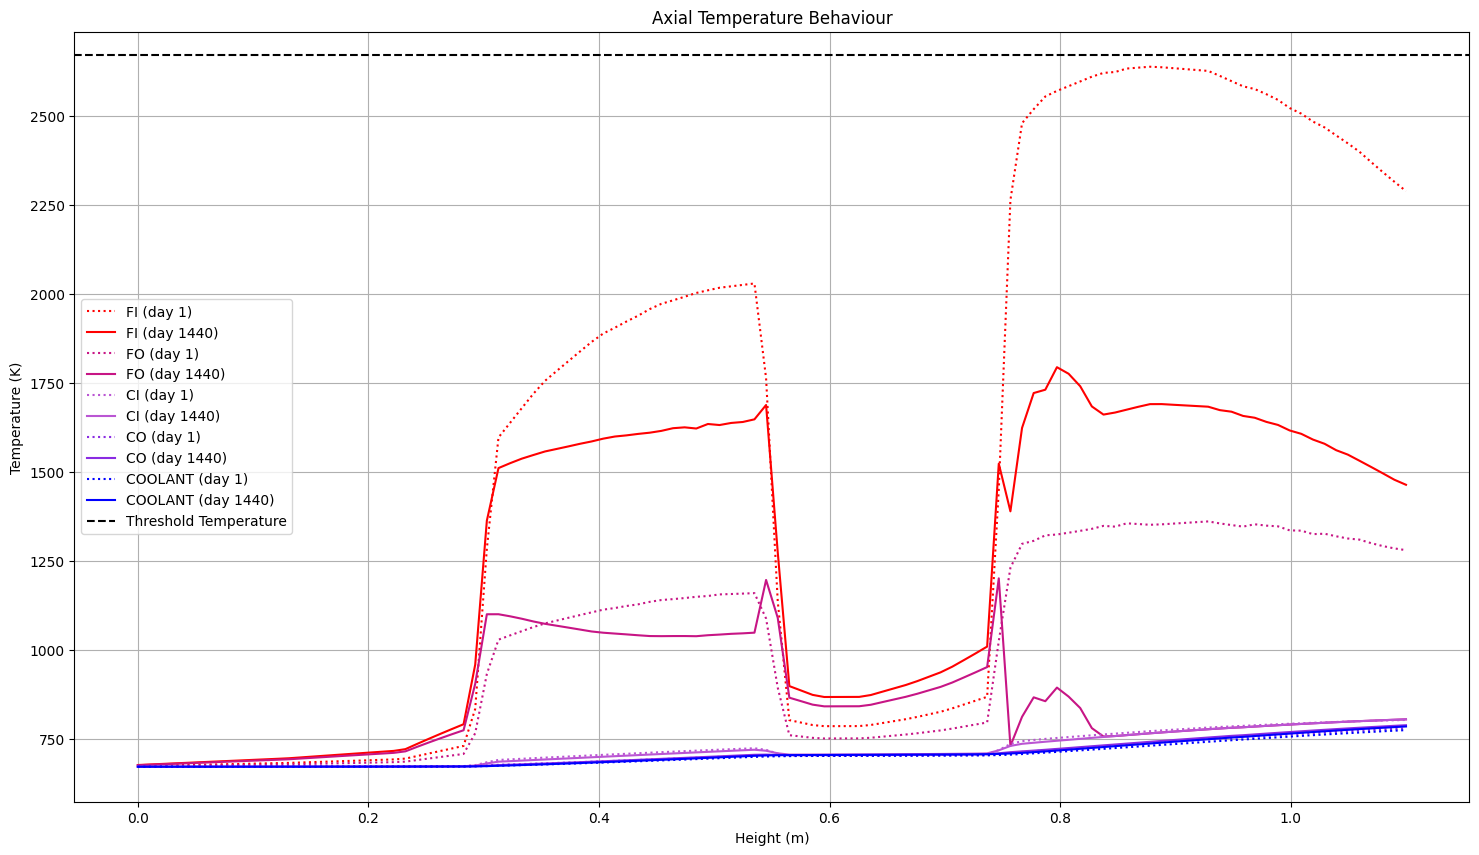

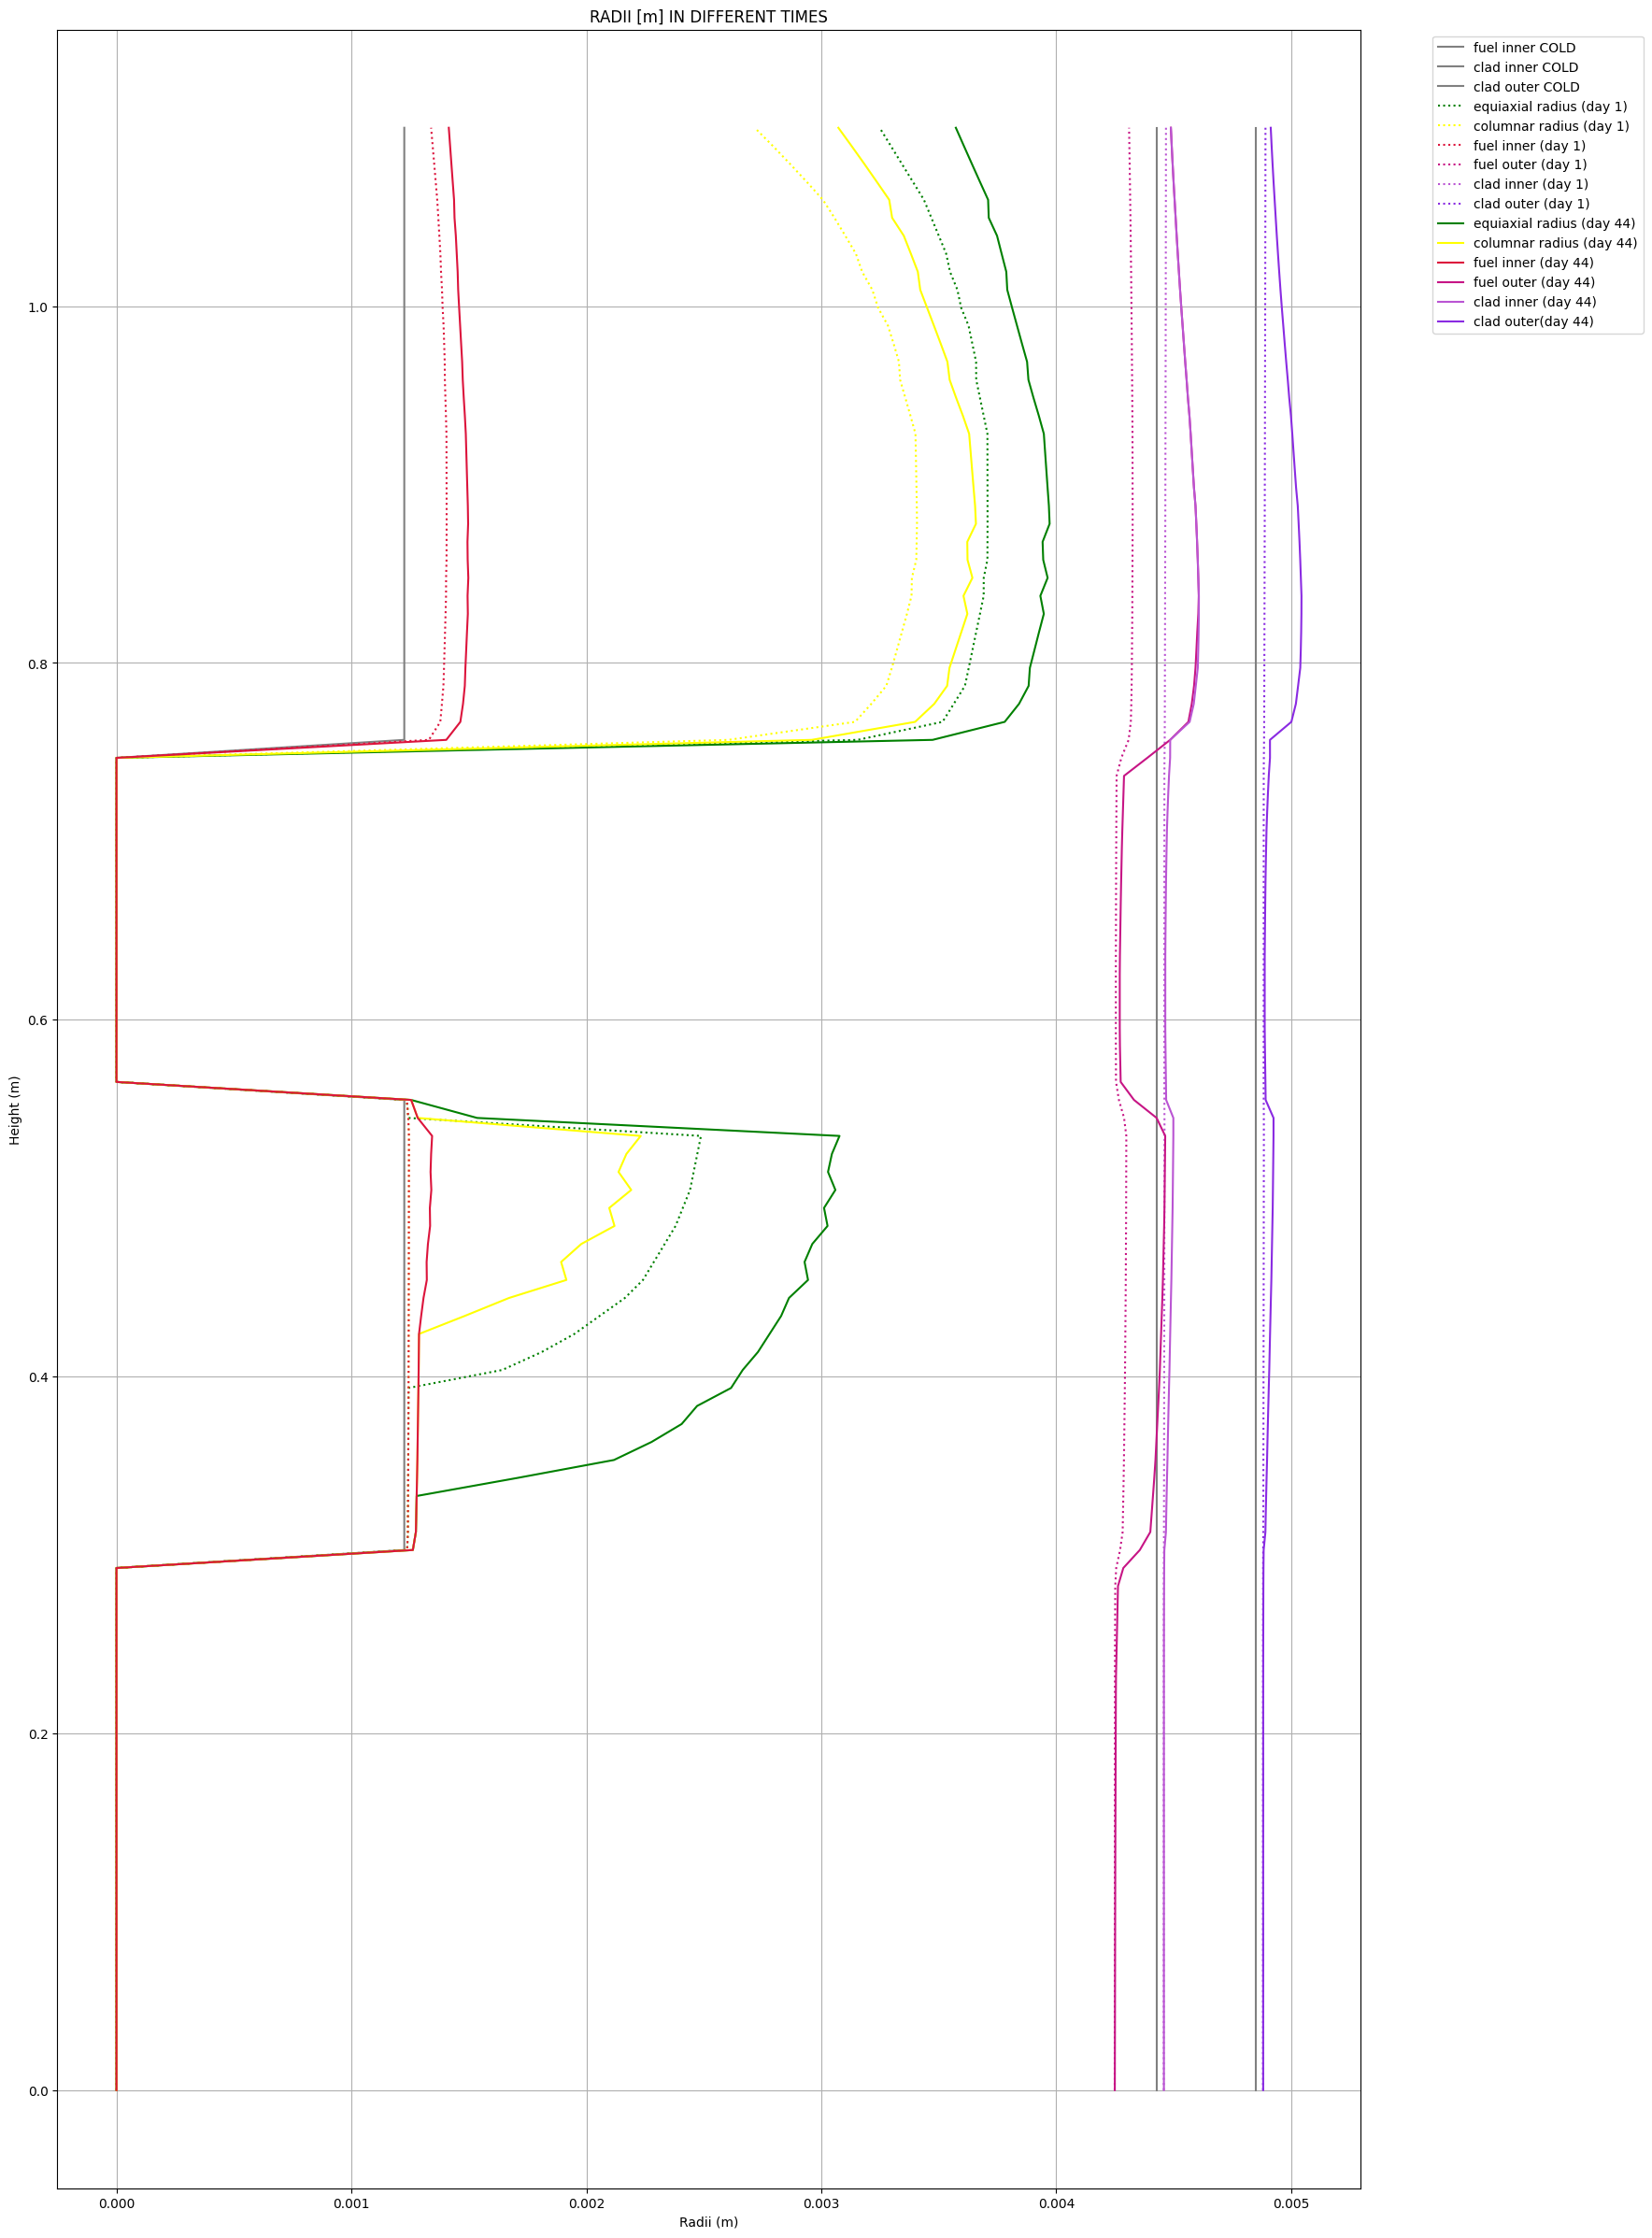

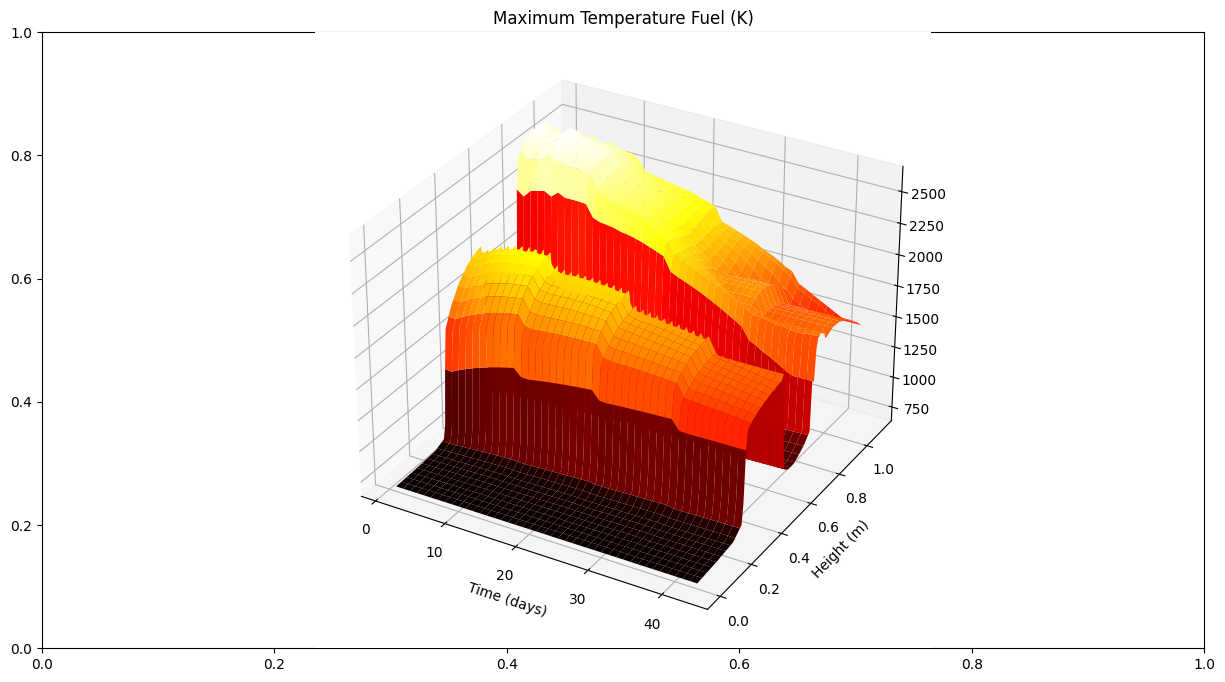

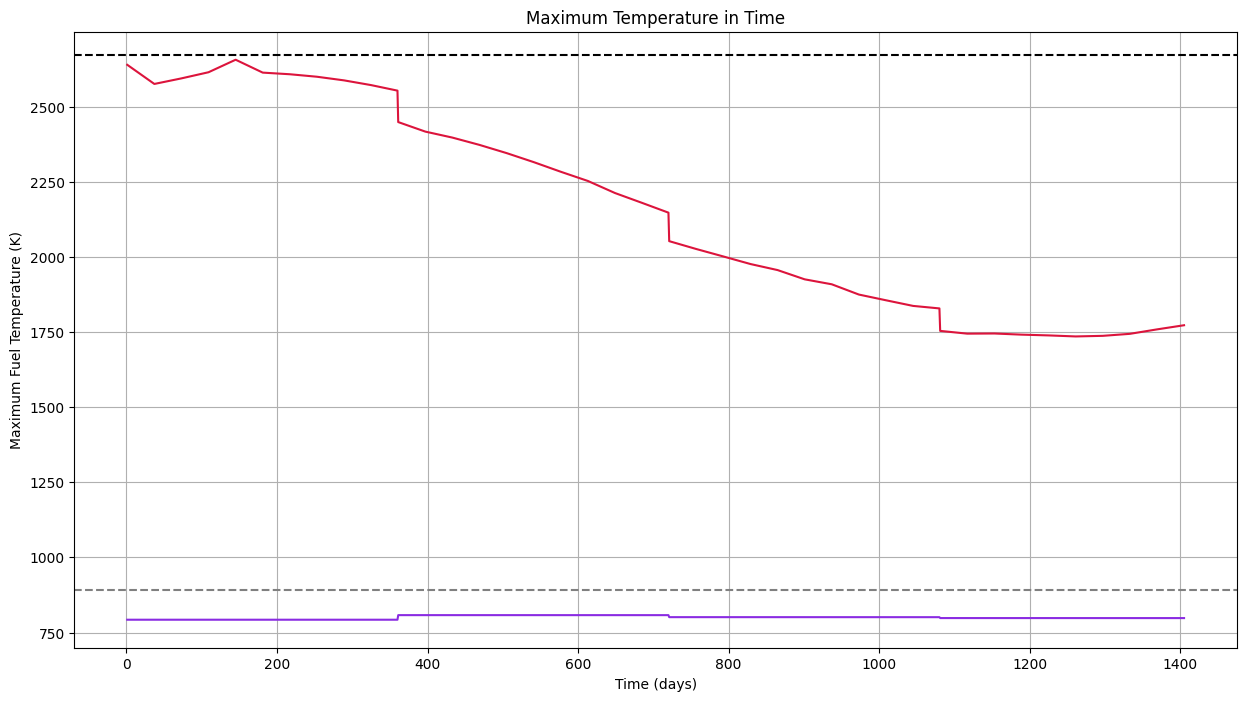

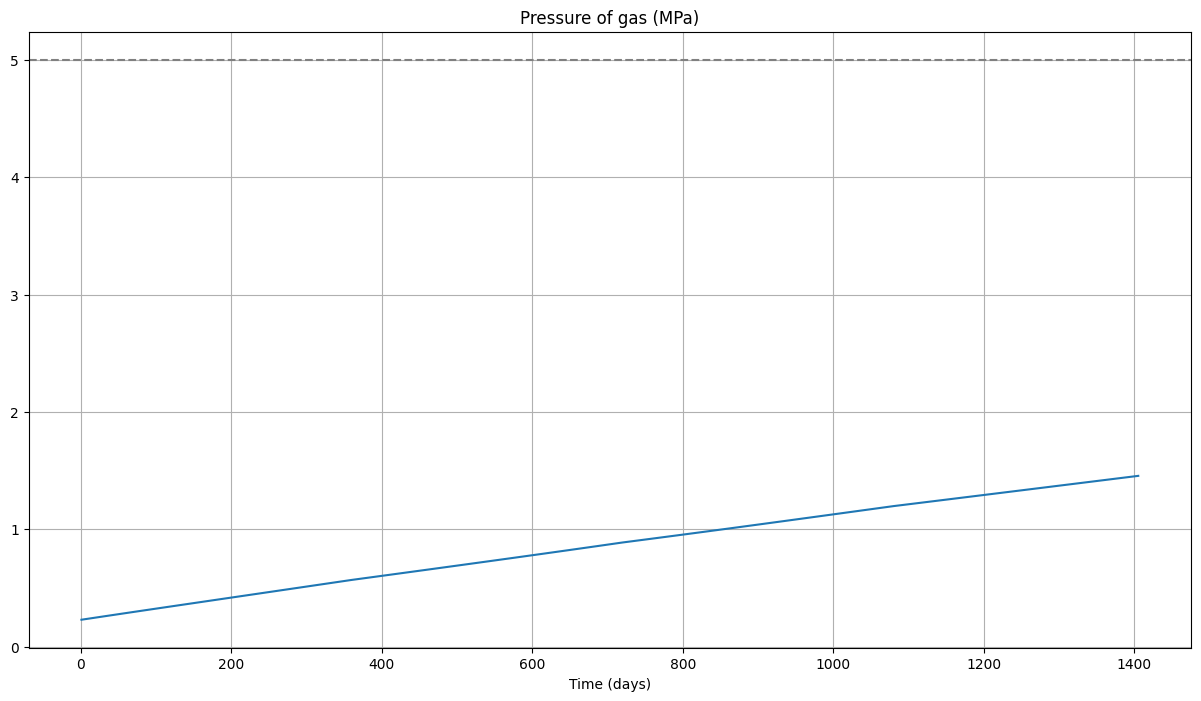

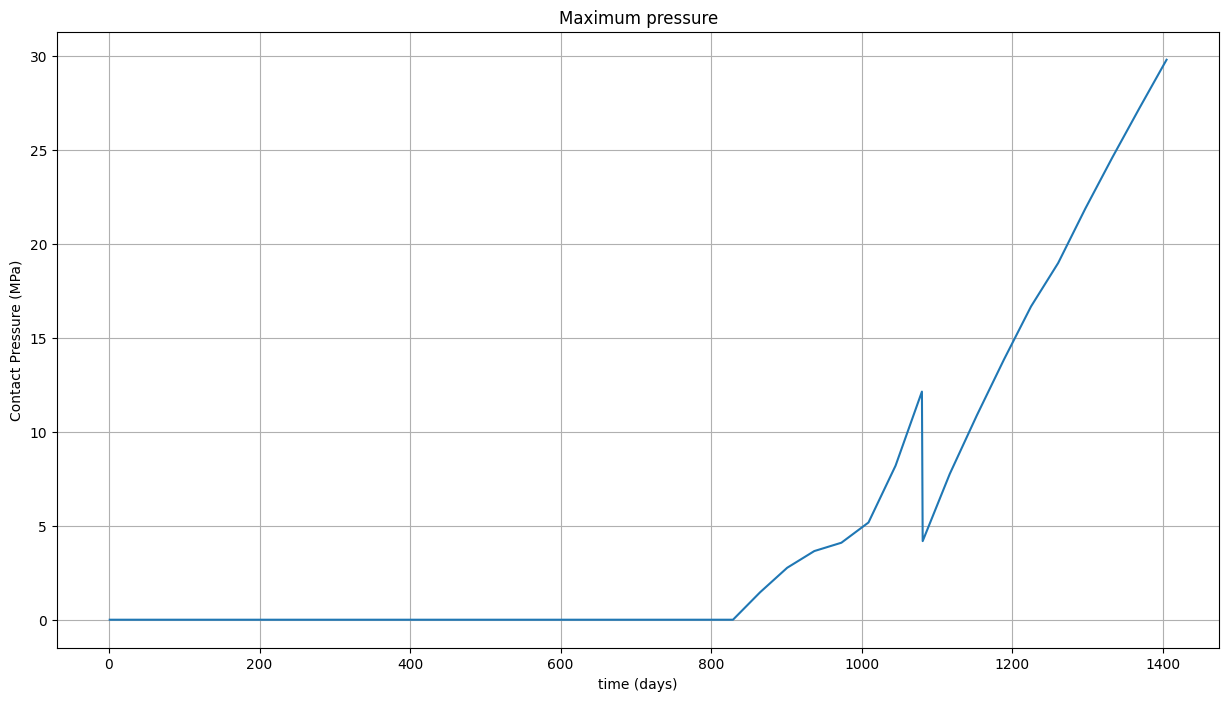

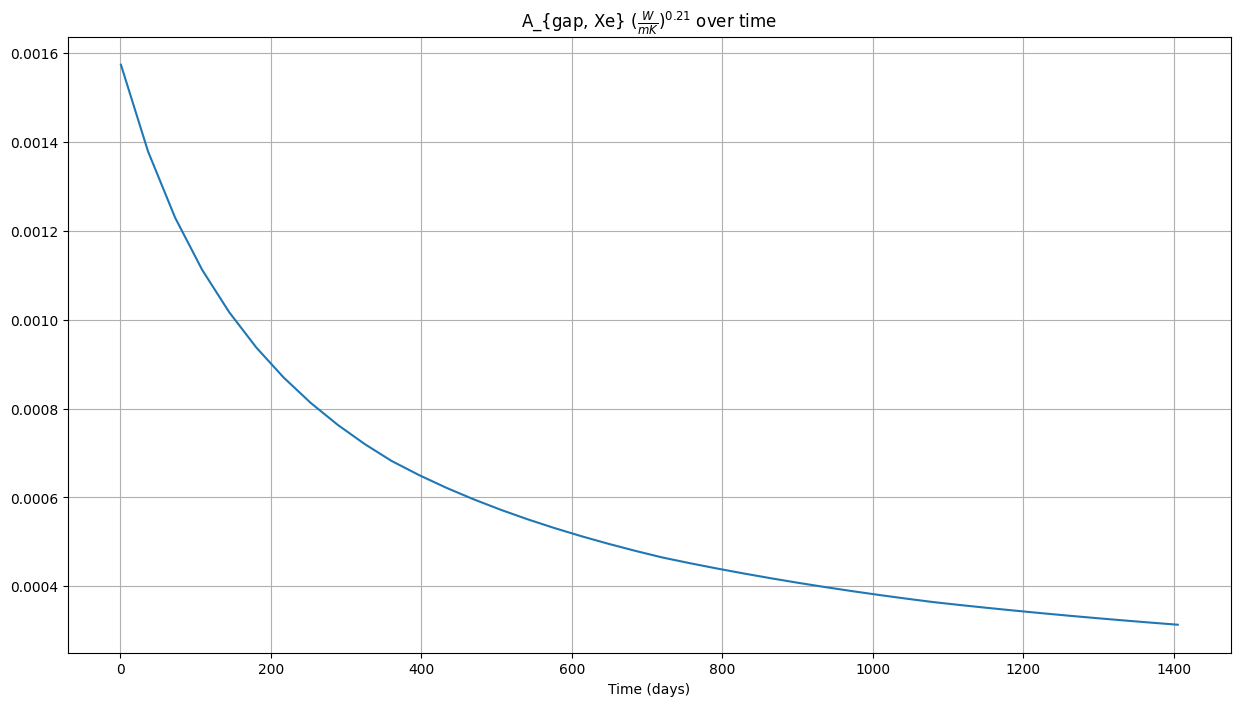

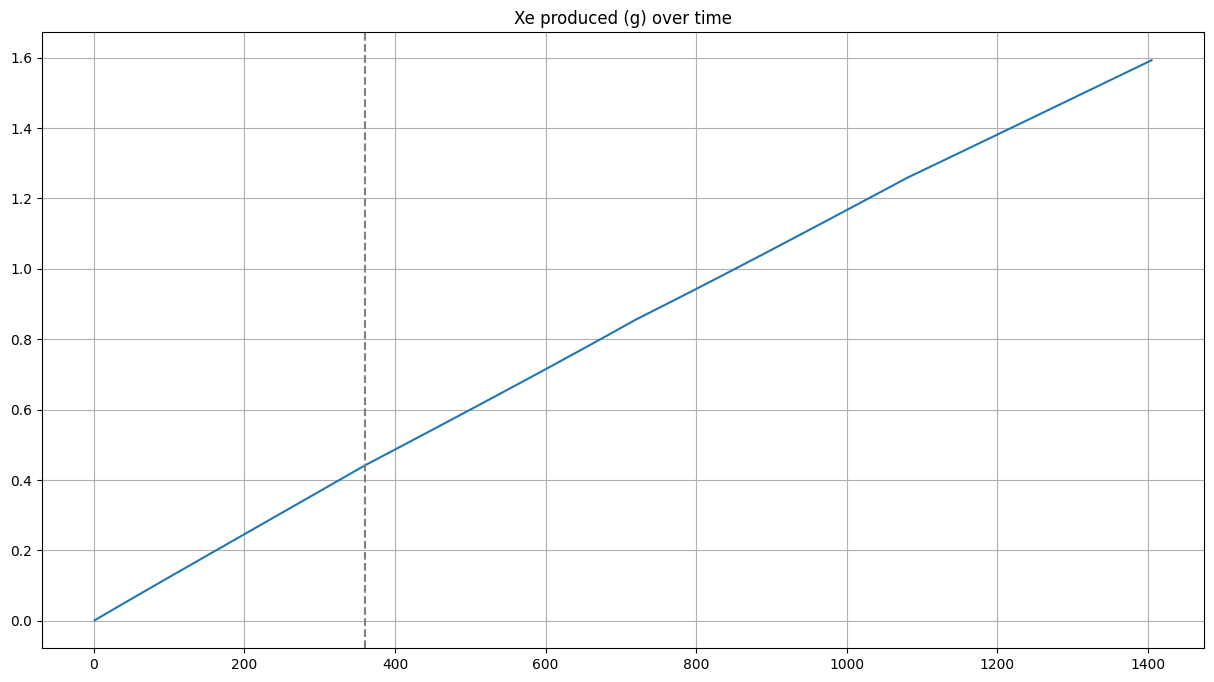

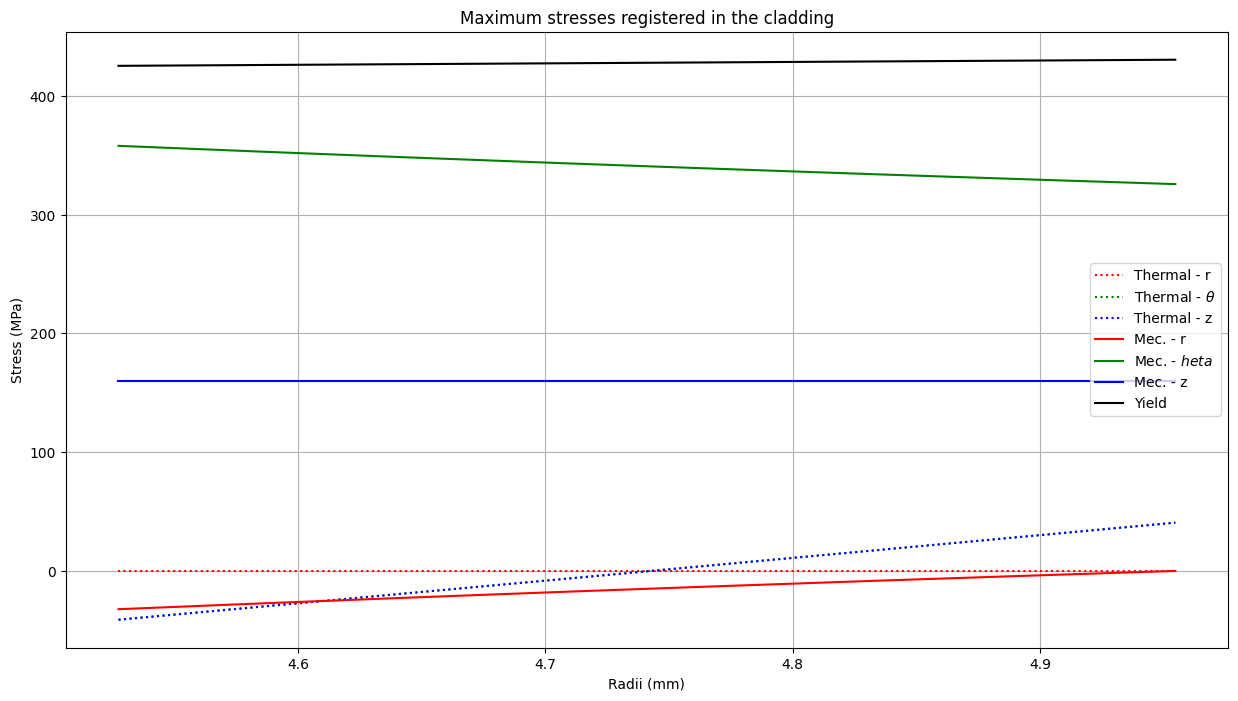

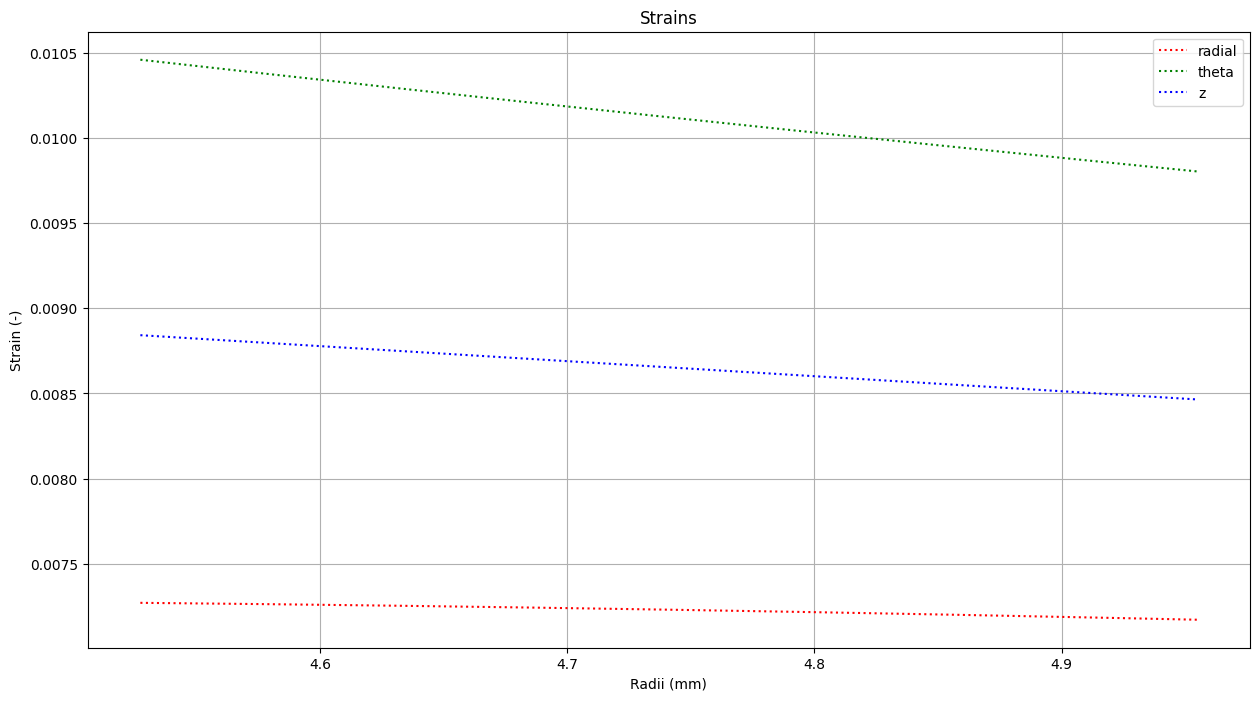

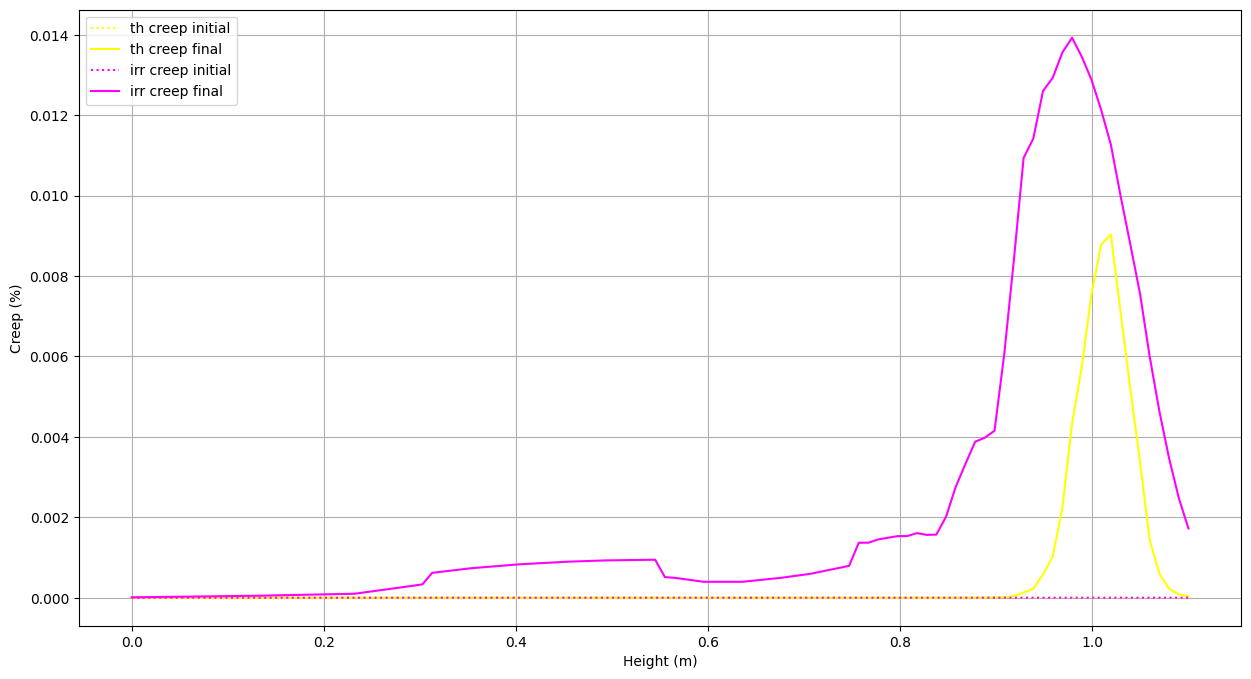

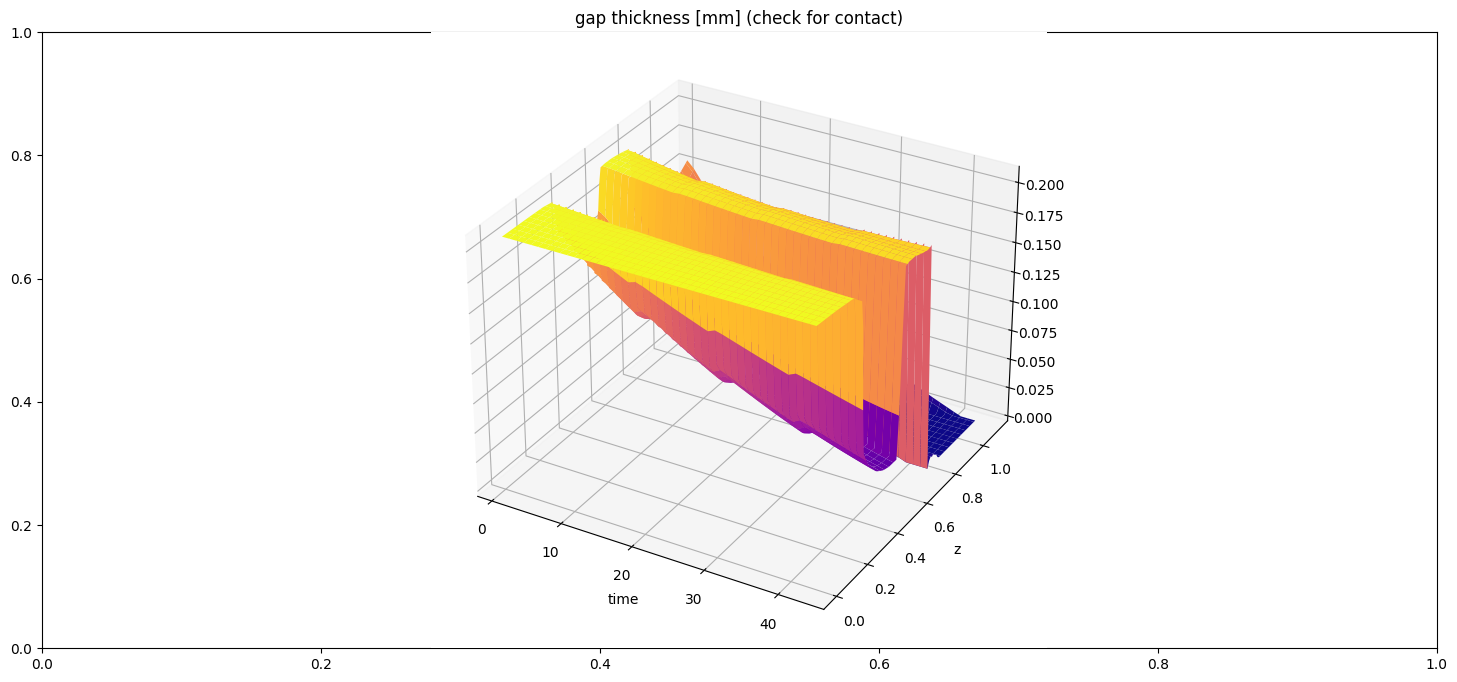

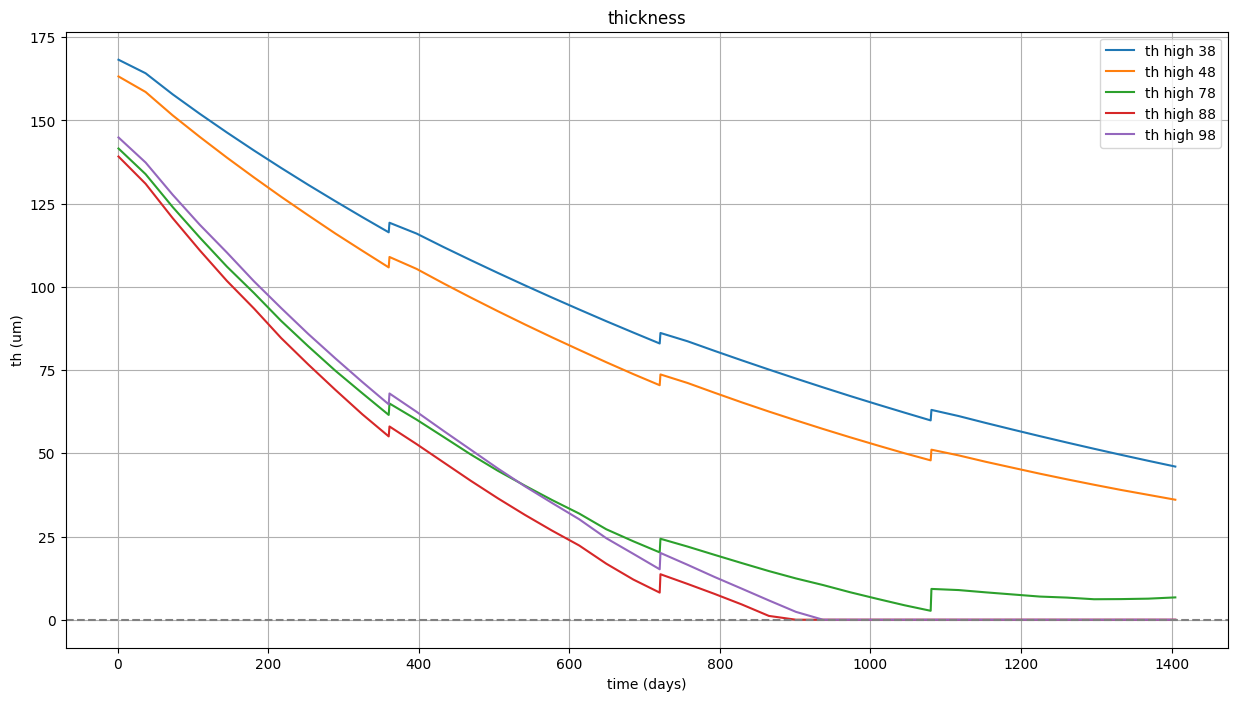

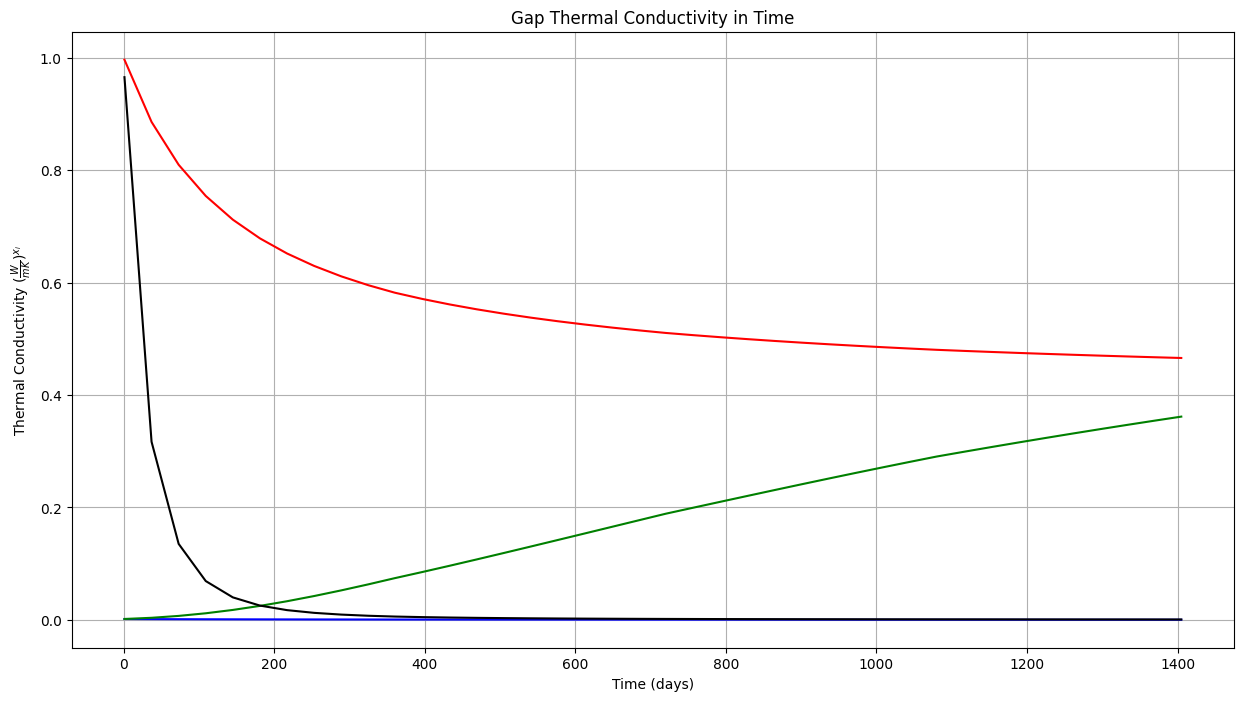

In [37]:
initial = 1
half = round(xxx/2)
time = xxx-1

tempo = t[1:time]

T_c_max = np.zeros(len(t))
for i in range(len(t)):
  T_c_max[i] = np.max(T_c_life[:,100,i])


###########################   PLOT THERMAL  ####################################

plt.figure(figsize=(18,10))
plt.title('Axial Temperature Behaviour')

plt.plot(z,T_f_life[:,0,initial], color='red', label='FI (day '+str(initial)+')', linestyle='dotted')
plt.plot(z,T_f_life[:,0,time], color='red', label='FI (day '+str(t[time])+')')

plt.plot(z,T_f_life[:,-1,initial], color='mediumvioletred', label='FO (day '+str(initial)+')', linestyle='dotted')
plt.plot(z,T_f_life[:,-1,time], color='mediumvioletred', label='FO (day '+str(t[time])+')')

plt.plot(z,T_c_life[:,0,initial], color='mediumorchid', label='CI (day '+str(initial)+')', linestyle='dotted')
plt.plot(z,T_c_life[:,0,time], color='mediumorchid', label='CI (day '+str(t[time])+')')

plt.plot(z,T_c_life[:,-1,initial], color='blueviolet', label='CO (day '+str(initial)+')', linestyle='dotted')
plt.plot(z,T_c_life[:,-1,time], color='blueviolet', label='CO (day '+str(t[time])+')')

plt.plot(z,T_coolant_life[:,initial], color='blue', label='COOLANT (day '+str(initial)+')', linestyle='dotted')
plt.plot(z,T_coolant_life[:,time], color='blue', label='COOLANT (day '+str(t[time])+')')

plt.axhline(2400+273, color='black',linestyle='dashed',label='Threshold Temperature')

plt.legend(loc='best')
plt.ylabel('Temperature (K)')
plt.xlabel('Height (m)')
plt.grid()
plt.show()
print('\n')


plt.figure(figsize=(18,30))
plt.title("RADII [m] IN DIFFERENT TIMES")

plt.plot(D_f_in_life[:,0]/2, z, label='fuel inner COLD',color='grey')
plt.plot(D_c_in_life[:,0]/2, z, label='clad inner COLD',color='grey')
plt.plot(D_c_out_life[:,0]/2, z, label='clad outer COLD',color='grey')

plt.plot(R_eq_life[:,initial], z, label='equiaxial radius (day '+str(initial)+')',color='green', linestyle='dotted')
plt.plot(R_col_life[:,initial], z, label='columnar radius (day '+str(initial)+')',color='yellow', linestyle='dotted')
plt.plot(D_f_in_life[:,initial]/2, z, label='fuel inner (day '+str(initial)+')',color='crimson', linestyle='dotted')
plt.plot(D_f_out_life[:,initial]/2, z, label='fuel outer (day '+str(initial)+')',color='mediumvioletred', linestyle='dotted')
plt.plot(D_c_in_life[:,initial]/2, z, label='clad inner (day '+str(initial)+')',color='mediumorchid', linestyle='dotted')
plt.plot(D_c_out_life[:,initial]/2, z, label='clad outer (day '+str(initial)+')',color='blueviolet', linestyle='dotted')

plt.plot(R_eq_life[:,time], z, label='equiaxial radius (day '+str(time)+')',color='green')
plt.plot(R_col_life[:,time], z, label='columnar radius (day '+str(time)+')',color='yellow')
plt.plot(D_f_in_life[:,time]/2, z, label='fuel inner (day '+str(time)+')', color='crimson')
plt.plot(D_f_out_life[:,time]/2, z, label='fuel outer (day '+str(time)+')', color='mediumvioletred')
plt.plot(D_c_in_life[:,time]/2, z, label='clad inner (day '+str(time)+')', color='mediumorchid')
plt.plot(D_c_out_life[:,time]/2, z, label='clad outer(day '+str(time)+')', color='blueviolet')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Radii (m)')
plt.ylabel('Height (m)')
plt.grid()
plt.show()
print('\n')



A,B = np.meshgrid(np.arange(1,time),z)

plt.figure(figsize=(15,8))
plt.title('Maximum Temperature Fuel (K)')
ax = plt.axes(projection='3d')
ax.plot_surface(A,B, T_f_life[:,0,1:time], cmap = plt.cm.hot)
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.show()
print('\n')




plt.figure(figsize=(15,8))

plt.title('Maximum Temperature in Time')
plt.plot(tempo, T_f_max[1:time], color='crimson', label = 'TF')
plt.plot(tempo, T_c_max[1:time], color='blueviolet', label = 'TC')
plt.axhline(2400+273, color='black',linestyle='dashed', label = 'TF Limit')
plt.axhline(620+273, color='grey',linestyle='dashed', label = 'TC Limit')
plt.xlabel('Time (days)')
plt.ylabel('Maximum Fuel Temperature (K)')
plt.grid()
plt.show()
print('\n')


##################################   MECHANICAL   #########################################


plt.figure(figsize=(15,8))
plt.plot(tempo, P_in_life[1:time]/1e6)
plt.xlabel('Time (days)')
plt.title('Pressure of gas (MPa)')
plt.axhline(5, color='grey',linestyle='dashed', label = 'Threshold')
plt.grid()
plt.show()
print('\n')

plt.figure(figsize=(15,8))
plt.title("Maximum pressure")
plt.plot(tempo, P_contact_time[1:time]/1e6)
plt.xlabel('time (days)')
plt.ylabel('Contact Pressure (MPa)')
plt.grid()
plt.show()
print('\n')

plt.figure(figsize=(15,8))
plt.title(r'A_{gap, Xe} $(\frac{W}{mK})^{0.21}$ over time')
plt.plot(tempo, A_gap_life[1:time])
plt.xlabel('Time (days)')
plt.grid()
plt.show()
print('\n')

plt.figure(figsize=(15,8))
plt.title("Xe produced (g) over time")
plt.plot(tempo, Xe_produced_life[1:time])
plt.axvline(360, color='grey',linestyle='dashed')
plt.grid()
plt.show()
print('\n')



# plotting the worst possible stresses on cladding
indexes = np.where(sigma_c_mec_theta_life == np.max(sigma_c_mec_theta_life))
a=indexes[0][0]
b=indexes[1][0]
c=indexes[2][0]
skere = np.linspace(D_c_in_life[a,c]/2,D_c_out_life[a,c]/2,n_rad)*1e3 # mm

plt.figure(figsize=(15,8))
plt.title("Stresses")
plt.plot(skere, sigma_c_th_r_life[a,:,c], color='red', linestyle='dotted', linewidth = 1.5,label='Thermal - r')
plt.plot(skere, sigma_c_th_theta_life[a,:,c], color='green', linestyle='dotted',linewidth = 1.5, label=r'Thermal - $\theta$')
plt.plot(skere, sigma_c_th_z_life[a,:,c], color='blue', linestyle='dotted', linewidth = 1.5,label='Thermal - z')

plt.plot(skere, sigma_c_mec_r_life[a,:,c], color='red', linestyle='-', linewidth = 1.5,label='Mec. - r')
plt.plot(skere, sigma_c_mec_theta_life[a,:,c], color='green', linestyle='-', linewidth = 1.5,label='Mec. - $\theta$')
plt.plot(skere, sigma_c_mec_z_life[a,:,c], color='blue', linestyle='-', linewidth = 1.5,label='Mec. - z')

plt.plot(skere, sigma02_life[a,:,c], color='black', linestyle='-', linewidth = 1.5,label='Yield')

plt.title('Maximum stresses registered in the cladding')
plt.xlabel('Radii (mm)')
plt.ylabel('Stress (MPa)')
plt.legend()
plt.grid()
plt.show()
print('\n')



plt.figure(figsize=(15,8))
plt.title("Strains")
plt.plot(skere, eps_c_r_life[a,:,c], color='red', linestyle='dotted', label='radial')
plt.plot(skere, eps_c_theta_life[a,:,c], color='green', linestyle='dotted', label='theta')
plt.plot(skere, eps_c_z_life[a,:,c], color='blue', linestyle='dotted', label='z')

plt.ylabel('Strain (-)')
plt.xlabel('Radii (mm)')
plt.legend()
plt.grid()
plt.show()
print('\n')



plt.figure(figsize=(15,8))
plt.plot(z, th_strain_life[:,0,initial], color='yellow', linestyle='dotted', label='th creep initial')
plt.plot(z, th_strain_life[:,0,time], color='yellow', linestyle='-', label='th creep final')

plt.plot(z, irrad_strain_life[:,0,initial], color='magenta', linestyle='dotted', label='irr creep initial')
plt.plot(z, irrad_strain_life[:,0,time], color='magenta', linestyle='-', label='irr creep final')

plt.xlabel('Height (m)')
plt.ylabel('Creep (%)')
plt.legend()
plt.grid()
plt.show()
print('\n')



plt.figure(figsize=(18,8))
plt.title("gap thickness [mm] (check for contact)")
ax = plt.axes(projection='3d')
ax.plot_surface(A,B, 1000*(D_c_in_life[:,1:time]-D_f_out_life[:,1:time])/2, cmap = plt.cm.plasma)
plt.xlabel('time')
plt.ylabel('z')
plt.show()
print('\n')



plt.figure(figsize=(15,8))
plt.title("thickness")
for zeta in [38, 48, 78, 88, 98]:
  plt.plot(tempo, (D_c_in_life[zeta,1:time]/2-D_f_out_life[zeta,1:time]/2)*1e6 , label="th high {}".format(zeta))

plt.axhline(0, color='grey',linestyle='dashed')
plt.xlabel('time (days)')
plt.ylabel('th (um)')
plt.legend(loc='best')
plt.grid()
plt.show()
print('\n')





plt.figure(figsize=(15,8))
plt.title(r'Gap Thermal Conductivity in Time')
plt.plot(tempo, A_gap_life[1:time], color='blue', label = 'Total Gap ThC')
plt.plot(tempo, A_gap_helium_life[1:time], color='green', label = 'Helium ThC')
plt.plot(tempo, A_gap_krypton_life[1:time], color='red', label = 'Krypton ThC')
plt.plot(tempo, A_gap_xenon_life[1:time], color='black', label = 'Xenon ThC')
plt.xlabel(r'Time (days)')
plt.ylabel(r'Thermal Conductivity $(\frac{W}{mK})^{x_i}$')
plt.grid()
plt.show()
print('\n')
